In [1]:
### IMPORTS 

import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd
import numpy as np

import datetime as dt
from dateutil.parser import parse

import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from functools import reduce

sns.set()
pd.set_option('display.max_colwidth', None)

In [2]:
import requests as r 

def retrieve_dataset(series:str, frequency:str, area:str, indicator:str, unit:str):
    """
    This function retrieves data from IMF dataservices API
    
    series: The series code 
    frequency: The dataset frequency
    area: The data region
    indicator: The Indicator code
    unit: The data measurement unit
    """

    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
    key = f'CompactData/{series}/{frequency}.{area}.{indicator}.{unit}'
    
    data = r.get(f'{url}{key}').json()
    
    tmp = data['CompactData']['DataSet']['Series']

    df = pd.DataFrame({tmp['@COMMODITY'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
         round(float(i['@OBS_VALUE']), 2) for i in tmp['Obs']}})
       
    return df 

copper_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "PCOPP",
    'unit': "USD"
}

oil_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "POILBRE",
    'unit': "USD"
}


df_copper = retrieve_dataset(copper_['series'],
                             copper_['frequency'],
                             copper_['area'],
                             copper_['indicator'],
                             copper_['unit'])

df_oil = retrieve_dataset(oil_['series'],
                             oil_['frequency'],
                             oil_['area'],
                             oil_['indicator'],
                             oil_['unit'])

print('\nCOPPER')
print(df_copper.info())

print('\nOIL')
print(df_oil.info())


COPPER
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 1990-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PCOPP   372 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None

OIL
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 1990-01-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POILBRE  372 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None


In [3]:
df = pd.merge(df_copper, df_oil, how='inner', right_index=True, left_index=True)

col_map = {
    "PCOPP": 'COPPER_USD_TON',
    "POILBRE": 'BRENT_OIL_USD_BLL'
}

df = df.rename(columns=col_map)

df.reset_index()

index  COPPER_USD_TON  BRENT_OIL_USD_BLL
0   1990-01-01         2365.56              21.25
1   1990-02-01         2358.94              19.93
2   1990-03-01         2625.70              18.37
3   1990-04-01         2685.23              16.49
4   1990-05-01         2740.34              16.34
..         ...             ...                ...
367 2020-08-01         6508.39              44.26
368 2020-09-01         6704.90              41.09
369 2020-10-01         6713.81              40.47
370 2020-11-01         7068.91              43.22
371 2020-12-01         7772.24              49.85

[372 rows x 3 columns]

# EDA - UNIVARIADA

## Plots Def

### F: Análise da Tendência (TREND)

* Monthly Distribuition
* Rolling Mean

In [4]:
def timeplot(ts, index_col='date', ax=None):
    """
    Plots the timeplot for a given timeseries
    
    """
    
    #ts = ts.set_index(index_col).iloc[:,0]
    
    var = [c for c in ts.columns.values if c !=index_col][0]
    
    sns.lineplot(data=ts, x=index_col, y=var, ax=ax)
    ax.title.set_text(f'{var} timeplot')
    
def trend_boxplot(data, y, ax, index_col='date', agg='M'):
    """
    Generates the boxplot for a timeseries
    """
    
    #data = data.set_index(index_col)
    
    if agg == 'M':
        data[agg] = data[index_col].dt.month
    elif agg == 'Y':
        data[agg] = data[index_col].dt.year
    elif agg == 'Y-M':
        data['year'] = data[index_col].dt.year
        data['month'] = data[index_col].dt.month
        data[agg] = data.apply(
            lambda row: str(row['year']) + '-' + str(row['month']), axis=1)
    else:
        print(f'Agg {agg} method not available')
    
    red_square = dict(markerfacecolor='r', marker='s')
    sns.boxplot(y=y, x=agg, ax=ax, data=data)
    #ax.boxplot(data)
    plt.setp(ax.get_xticklabels(), rotation = (45), fontsize = 10, ha='right')
    ax.title.set_text(f'Boxplot')

def rolling_mean_plot(data, var, roll_win=30, ax=None):
    """
    Plots rolling mean for a give time series
    
    :param data: time series data
    :type data: pd.DataFrame
    :param var: name of the variable to compute rolling mean
    :type var: string
    :param roll_win: rolling window size
    :type roll_win: int
    :param min_win: minimum window size 
    :type min_win: int
    """
    
    roll = data[var].rolling(roll_win).mean()
    sns.lineplot(roll.index, roll.values, ax=ax)
    #ax.plot(roll.index, roll.values, label=f'{var} rolling mean')
    #plt.setp(ax.get_xticklabels(), rotation = (45), fontsize = 10, ha='right')
    ax.title.set_text(f'{var} rolling mean')

def trend_plots(ts, timestamp='date', series=None, s='M', fig_size=(12,8), **kwargs):
    
    roll_win = kwargs.get('roll_win', 12)
    rot = kwargs.get('ROT', False)
    
    #fig = plt.figure(figsize=(12,8))
    #ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    #ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
    #ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=3)
    
    fig = plt.figure(figsize=fig_size, constrained_layout=True)
    
    fig.suptitle(f"Trend Analysis - {series}", fontsize=20, y=1.08)
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[:, 1:])   
    
    timeplot(ts, timestamp, ax=ax1)
    rolling_mean_plot(ts, series, ax=ax2, roll_win=roll_win)
    trend_boxplot(ts, series, ax=ax3, index_col=timestamp, agg=s)
    
    if rot:
        rolling_mean_plot(ts, series, ax=ax1, roll_win=roll_win)
           
    
    

### F: Análise da Sazonalidade

* Seasonality Plots
    - Mensal (Ano-Mês)
    - Semanal (Week Of Month)
    - Dia da Semana (Week Day)

In [5]:
from math import ceil

def week_of_month(dt):
    """ 
    Small Hack that returns the week of the month 
    for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day

    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    
    w = int(ceil(adjusted_dom/7.0))
    
    if w > 5:
        w = 5
    else:
        pass
    
    return w

def datetime_variables(data, index='date'):
    
    data = data.set_index(index)
    
    data['M'], data['Y'] = data.index.month, data.index.year
    data['Y-M'] = data.apply(
        lambda row: str(str(row['Y']) + '-' + str(row['M'])), axis=1)
    data['WD'] = data.index.weekday +1 # adds one to make monday #1 day and sunday #7
    
    data['Q'] = data.index.quarter.astype('object') # Quarters from 1 
    
    data = data.reset_index()
       
    data['WoM'] = data.apply(lambda row:
                             week_of_month(row[index]), axis=1)
    
     
    
    return data

def seasonality_line_plot(data:pd.DataFrame, var=None, index='date', s='M', cat='Y', ax=None):
    """
    
    Plots the seasonality plot for a given series 
    for the required season.
    
    :param data: pd.DataFrame of the data
    :param index: column to be used as index
    :param s: season
    :param cat: categorical variable higlight the seasons
    """
    
    #TODO: IMPLEMENT ASSERTION FOR M, Y, Y-M, WD, WoM
    
    data = datetime_variables(data, index)
    
    data = data.groupby([s, cat], as_index=False).sum()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    else:
        pass
    
    sns.lineplot(data=data, x=s, y=var, hue=cat, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(ax.get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    
    ttl_map = {'M': 'month', 'Y': 'year',
               'Y-M': 'Year-Month', 'WD': 'Weekday',
               'WoM': 'Week Of Month', 'Q': 'Quarters'}
    
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='left', borderaxespad=0.)
    #ax.legend(loc='upper right', bbox_to_anchor=(0.5, -0.05),
    #          fancybox=True, shadow=True, ncol=5, fontsize=10)
    ax.legend(loc='upper left', fancybox=True, shadow=True, fontsize=10)         
    ax.title.set_text(f'Seasonality plot - Season: {ttl_map[s]} - Time Series: {var}')

def season_swarm_plot(data:pd.DataFrame, var=None, index='date', s='M', cat='Y', ax=None):
    """
    
    Plots the seasonality swarm plot for a given series 
    for the required season.
    
    :param data: pd.DataFrame of the data
    :param index: column to be used as index
    :param s: season
    :param cat: categorical variable higlight the seasons
    """
    
    #TODO: IMPLEMENT ASSERTION FOR M, Y, Y-M, WD, WoM
    
    data = datetime_variables(data, index)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    else:
        pass
    
    sns.swarmplot(data=data, x=s, y=var, hue=cat, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(ax.get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    
    ttl_map = {'M': 'month', 'Y': 'year',
               'Y-M': 'Year-Month', 'WD': 'Weekday', 'WoM': 'Week Of Month'}
    
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='right', borderaxespad=0.)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5, fontsize=10)
    ax.title.set_text(f'Seasonality Swarm plot - Season: {ttl_map[s]} - Time Series: {var}')    

def seasonality_plots(ts, timestamp='date', series=None, fig_size=(24,12)):
    
    fig = plt.figure(figsize=fig_size, constrained_layout=True)
    
    fig.suptitle(f"Seasonality Analysis - {series}", fontsize=20, y=1.08)
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[:, 1:])
    
    #monthly seasonality
    seasonality_line_plot(data=ts, var=series, index=timestamp, ax=ax1)
    
    #quarterly seasonality
    seasonality_line_plot(data=ts, var=series, index=timestamp, s='Q', cat='Y', ax=ax2)
    
    #monthly boxplot
    trend_boxplot(ts, series, ax=ax3, index_col=timestamp, agg='M')
    
    fig.tight_layout()

    plt.show()
    

## COPPER

In [6]:
df.head()

COPPER_USD_TON  BRENT_OIL_USD_BLL
1990-01-01         2365.56              21.25
1990-02-01         2358.94              19.93
1990-03-01         2625.70              18.37
1990-04-01         2685.23              16.49
1990-05-01         2740.34              16.34

### TREND

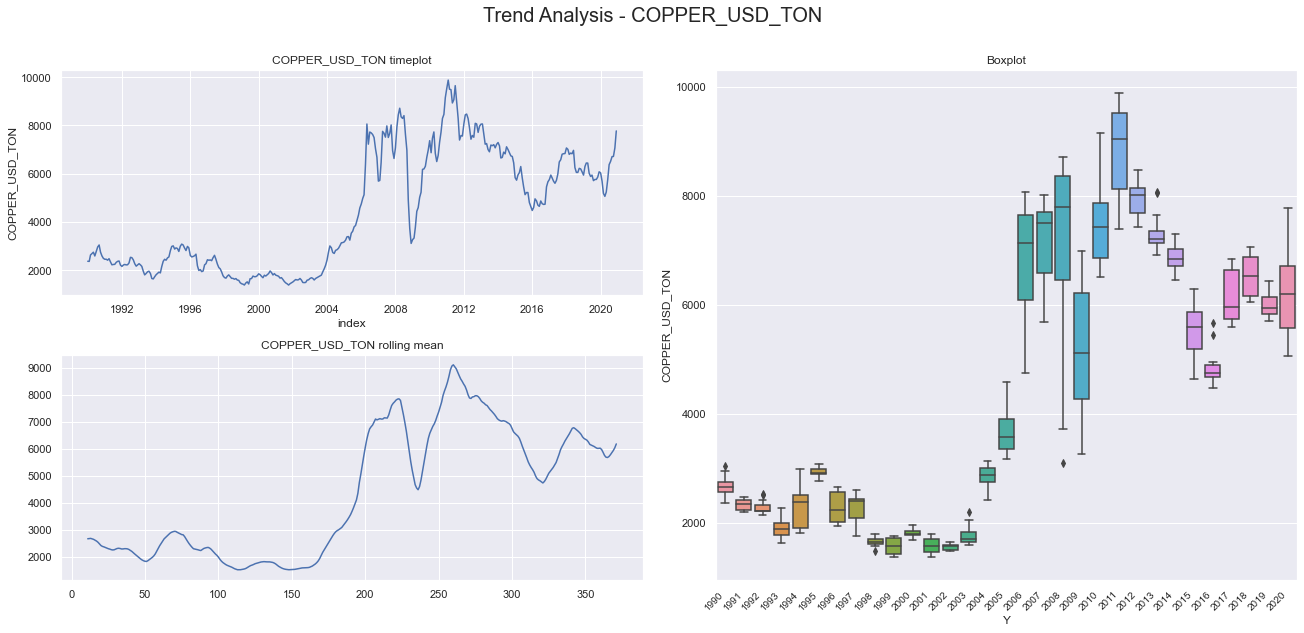

In [7]:
#- COMGAS 
trend_plots(df.reset_index()[['index', 'COPPER_USD_TON']],
            series='COPPER_USD_TON', timestamp='index',  s='Y',
            fig_size=(18,8), ROT=False)

Fig = go.Figure()

#Fig.add_trace(go.Scatter(
#    x=df.reset_index().index,
#    y=df.reset_index().COPPER_USD_TON))

### Seasonality

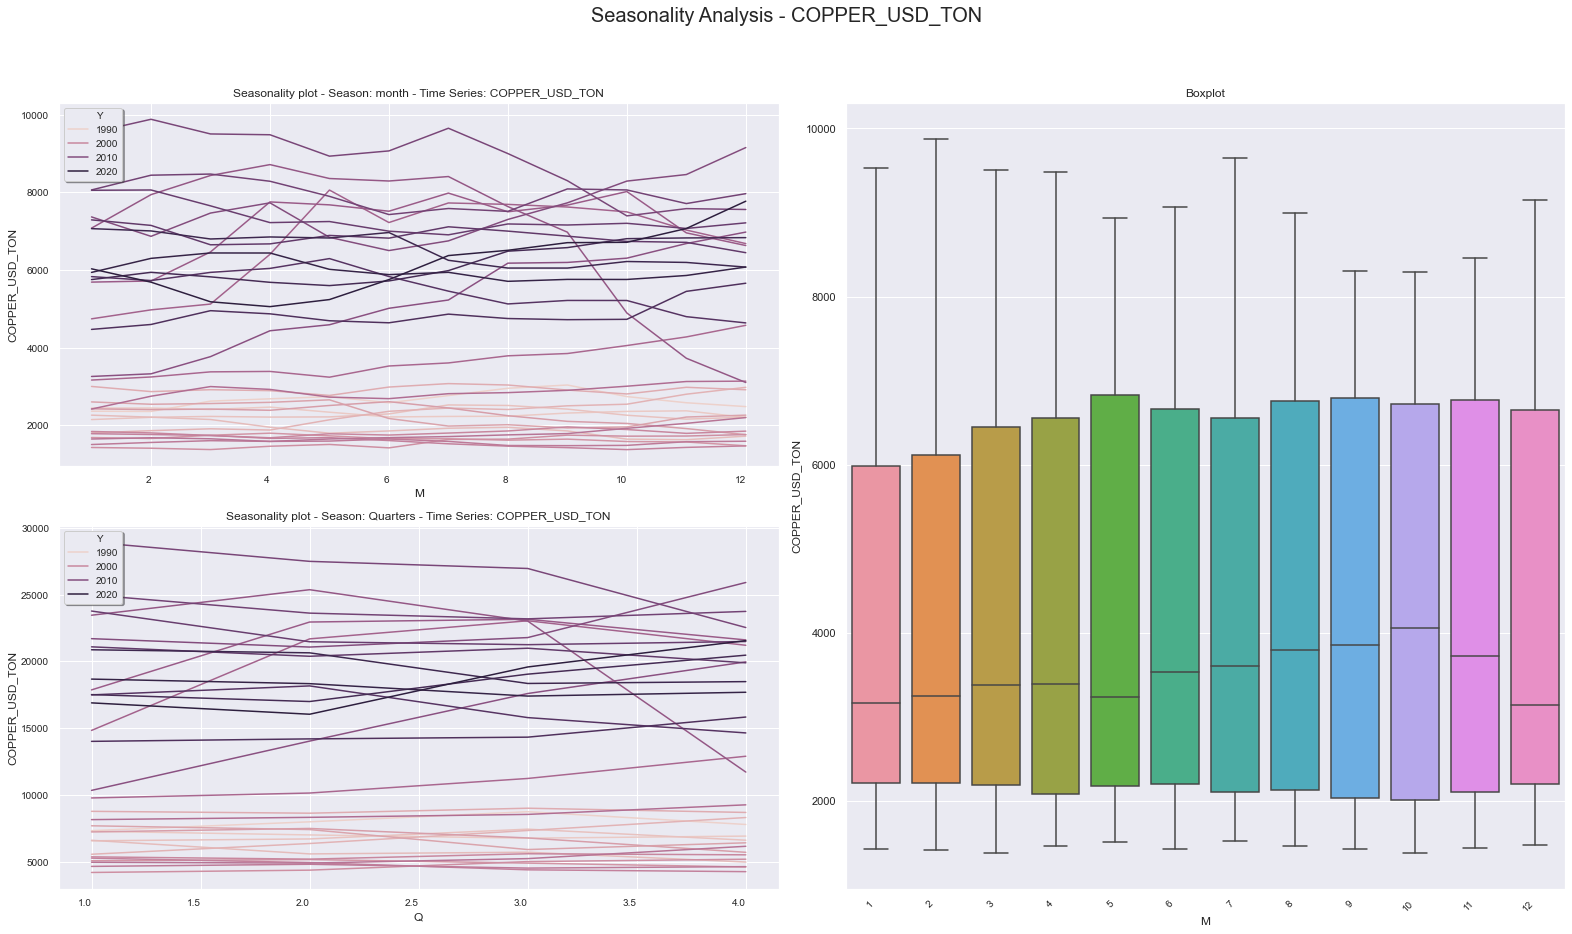

In [8]:
seasonality_plots(df.reset_index()[['index', 'COPPER_USD_TON']],
            series='COPPER_USD_TON', timestamp='index', fig_size=(22,12))

### Tt e St: RESULTADOS

**TREND**

- Entre 1990 e 2003 existe uma tendência de queda nos preços; estes comportamentos são observados com maior clareza entre 1990 e 1994 e, posteriormente, entre 1996 e meados dos anos 2000. Entre 2000 e 2004 o level é aproximadamente estável. 

    - Pode ter existido a presença de dois ciclos curtos entre 90-94 e 96-00????
    
    
- A partir de 2004, os preços sofrem um expressivo aumento, saindo de um patamar de cerca de 3000 USD/ton para 8000 USD/ton em 2007 e, posteriormente, alcancançando um pico de 10000 USD/ton. 


- Após o pico em 2010, há uma constante tendência de queda, que se manteve até 2016, quando os preços chegaram a 5000 USD/ton e voltaram a subir, em seguida. 
        

**Seasonality**
- Os plots de sazonalidade não apresentam nenhum padrão claro de sazonalidade;
- Durante os anos 90, não existe nenhum padrão claro de sazonalidade, mas ocorre uma variação nos patamares da série, que variam entre 1000 e 5000 USD/ton
- Há um aparente padrão de sazonalidade para dois períodos da série. Nestes períodos, os preços entre Q2 e Q3 foram mais altos e mais baixos nos Q1 e Q4, no entanto este padrão não ocorre de forma sistemática na série.

# BRENT OIL

In [9]:
df.head()

COPPER_USD_TON  BRENT_OIL_USD_BLL
1990-01-01         2365.56              21.25
1990-02-01         2358.94              19.93
1990-03-01         2625.70              18.37
1990-04-01         2685.23              16.49
1990-05-01         2740.34              16.34

## TREND

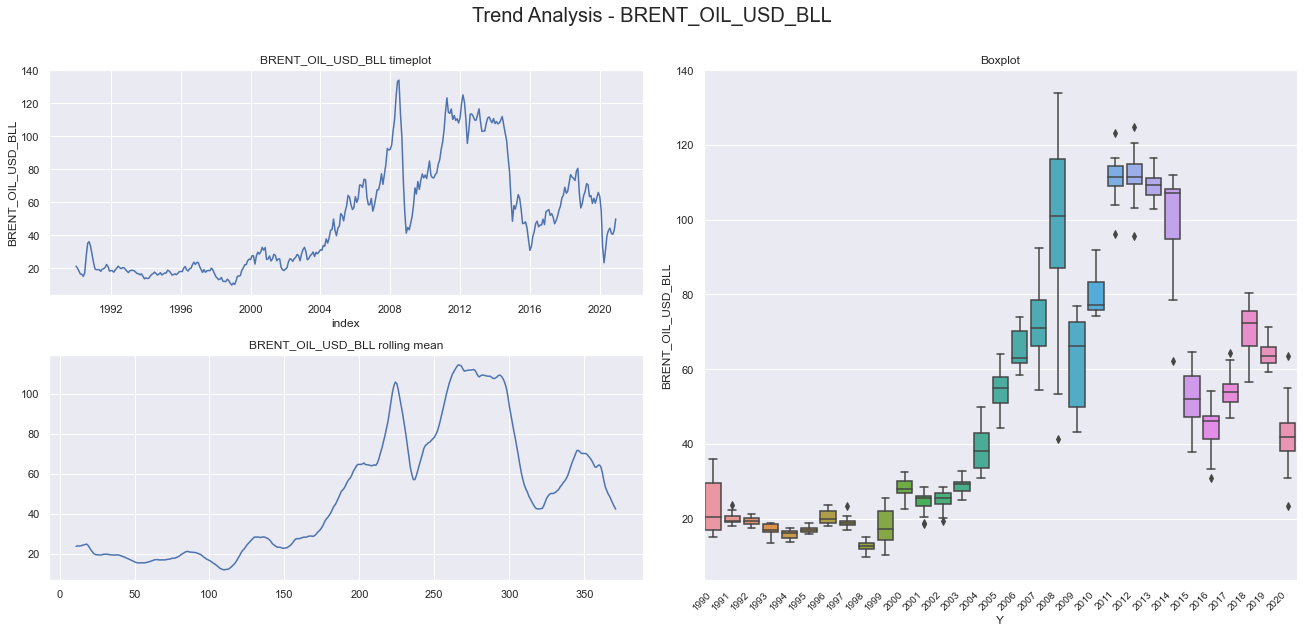

In [10]:
trend_plots(df.reset_index()[['index', 'BRENT_OIL_USD_BLL']],
            series='BRENT_OIL_USD_BLL', timestamp='index',  s='Y',
            fig_size=(18,8), ROT=False)

Fig = go.Figure()

Fig.add_trace(go.Scatter(
    x=df.reset_index()['index'],
    y=df.reset_index().BRENT_OIL_USD_BLL))

## SEASONALITY

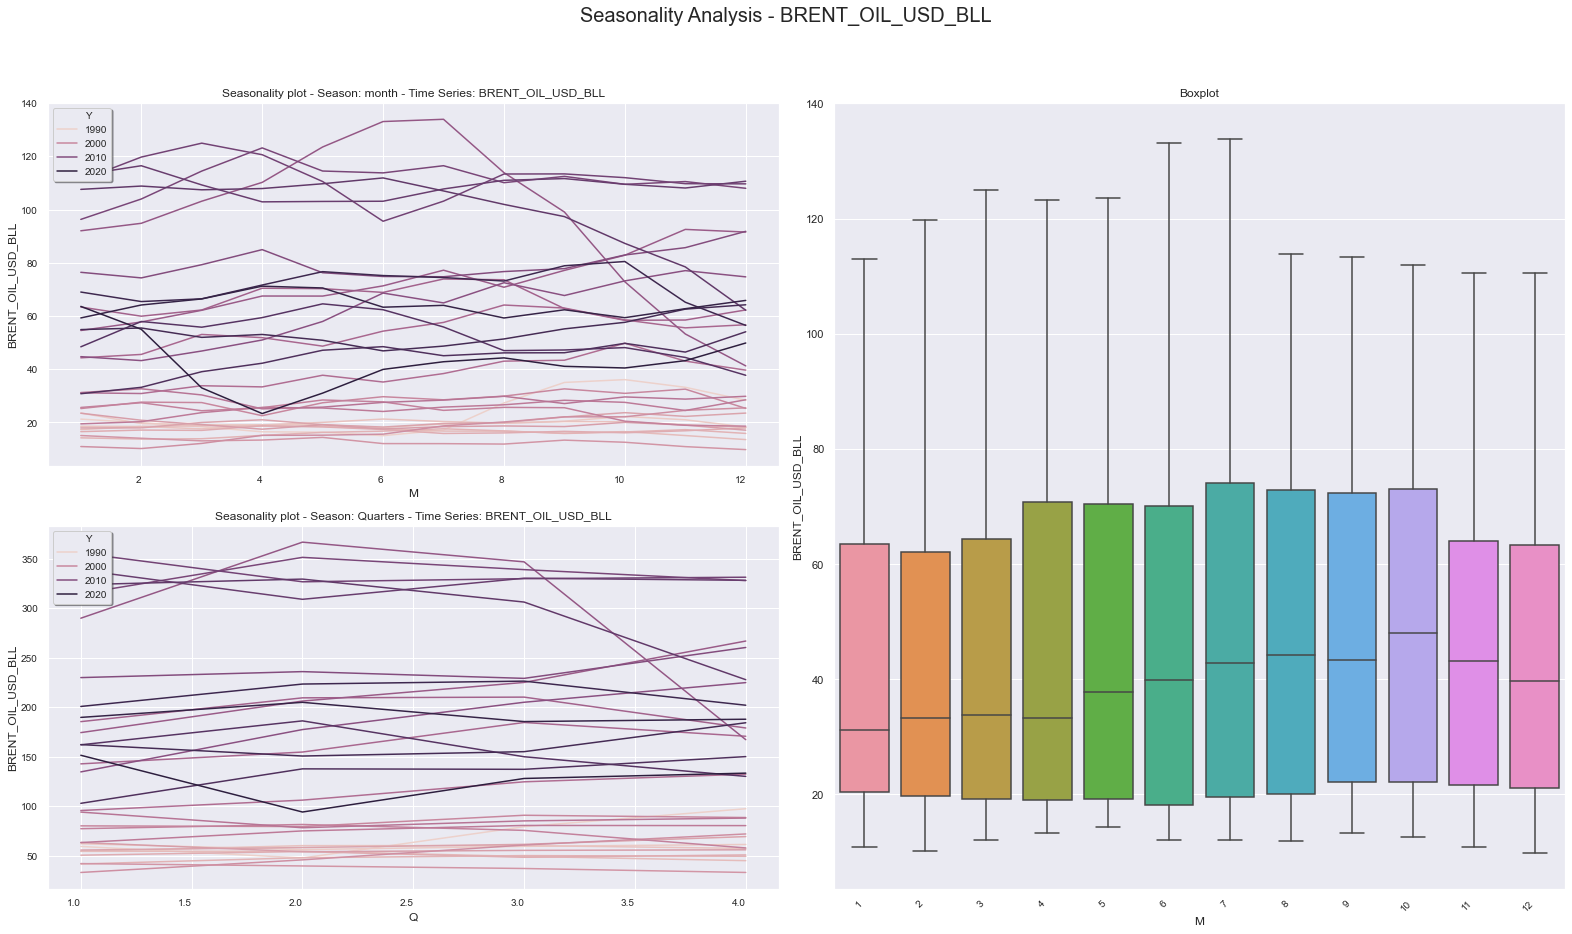

In [11]:
seasonality_plots(df.reset_index()[['index', 'BRENT_OIL_USD_BLL']],
            series='BRENT_OIL_USD_BLL', timestamp='index', fig_size=(22,12))

## Series Decomposition



* Time Series can be modeled considering four components. Three of these components are systematic (Trend, Seasonality and Level) and one non-systematic component (noise)

* There are different techinques to decompose a time series. The naive approach considers wheter the time series is Multiplicative or Aditive.

* For the presented analysis the time series are modeled as additive, therefore:
    * yt = Lt + Tt + St + noise.

* (Additive models are linear and the model used here is linear (ARIMA))

REFS: 
- Shumeli et al., Pratical Time Series Forecasting with R (Section 2.2 - Time Series Components);
- Athanasopoulos, Forecasting Principals and Practice (Ch. 6.3)
- https://github.com/danielfaioli/priceforecast/blob/master/notebooks/eda_oil_cooper_imf.ipynb


**classical/naive decomposition**

1. Tt = 2*m-MA, m é par; Tt = m-MA, cc
2. detrendTt = yt-Tt
3. St=mean(detrendTt)
4. noise=yt-Tt-St

**Seasonal Decomposition using LOESS**

- https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html
- http://www.gardner.fyi/blog/STL-Part-I/ http://www.gardner.fyi/blog/STL-Part-II/
- http://www.gardner.fyi/blog/STL-Part-II/

In [12]:
def ts_decompose(ts, method='STL', **kwargs):
    
    robust = kwargs.get('robust', False)
    period = kwargs.get('period', 7)
    
    decompose_model = kwargs.get('decompose_model', 'additive')
    
    weights = kwargs.get('weights', True)
       
    def naive_decompose(ts, model='additive'):
        
        dec = seasonal_decompose(ts, model)
        
        return dec
    
    def stl_decompose(ts, robust=False, period=7):
        
        print(robust, period)
        dec = STL(ts, robust, period)
        dec = dec.fit()
        
        return dec
    
    if method=='STL':
        dec = stl_decompose(ts, robust=robust, period=period)
    elif method=='naive':
        dec = naive_decompose(ts, decompose_model)
    else:
        print(f'method {method} does not exist')
        
    dec.plot(weights=weights)
    plt.rc("figure", figsize=(12,12))
    plt.show();
        
    return dec

In [13]:
df.head()

COPPER_USD_TON  BRENT_OIL_USD_BLL
1990-01-01         2365.56              21.25
1990-02-01         2358.94              19.93
1990-03-01         2625.70              18.37
1990-04-01         2685.23              16.49
1990-05-01         2740.34              16.34

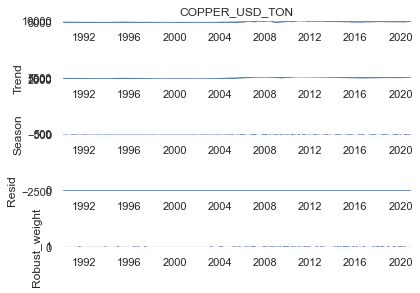

In [14]:
# COPPER

period = 12

stl_dec_robust = STL(df.COPPER_USD_TON, robust=True, period=period).fit()
stl_dec = STL(df.COPPER_USD_TON, robust=False).fit()

stl_dec_robust.plot(weights=True)

#stl_dec.plot(weights=True)

plt.show()


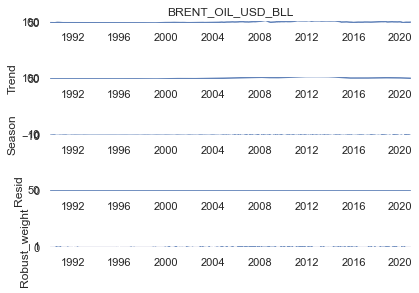

In [15]:
# BRENT OIL

period = 12

stl_dec_robust = STL(df.BRENT_OIL_USD_BLL, robust=True, period=period).fit()

stl_dec_robust.plot(weights=True)

#stl_dec.plot(weights=True)

plt.show()


### Seasonal Adjusted Tests

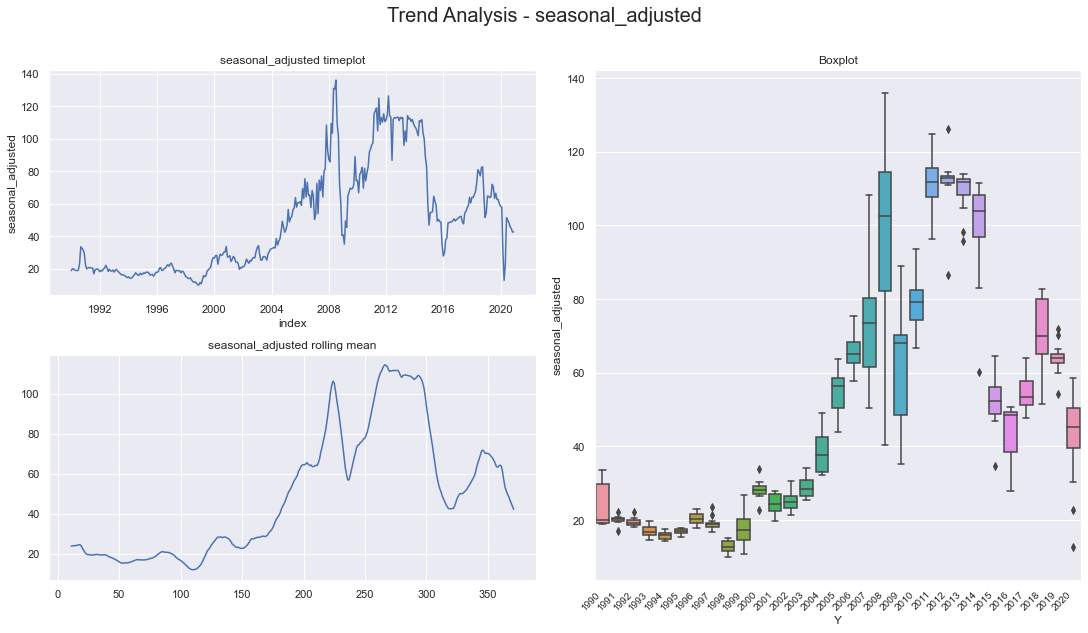

In [16]:
seasonal_adjusted = pd.DataFrame(
    df.BRENT_OIL_USD_BLL - stl_dec_robust.seasonal,
    columns=['seasonal_adjusted']).reset_index()


trend_plots(seasonal_adjusted,
            series='seasonal_adjusted', s='Y',
            fig_size=(15,8), timestamp='index')

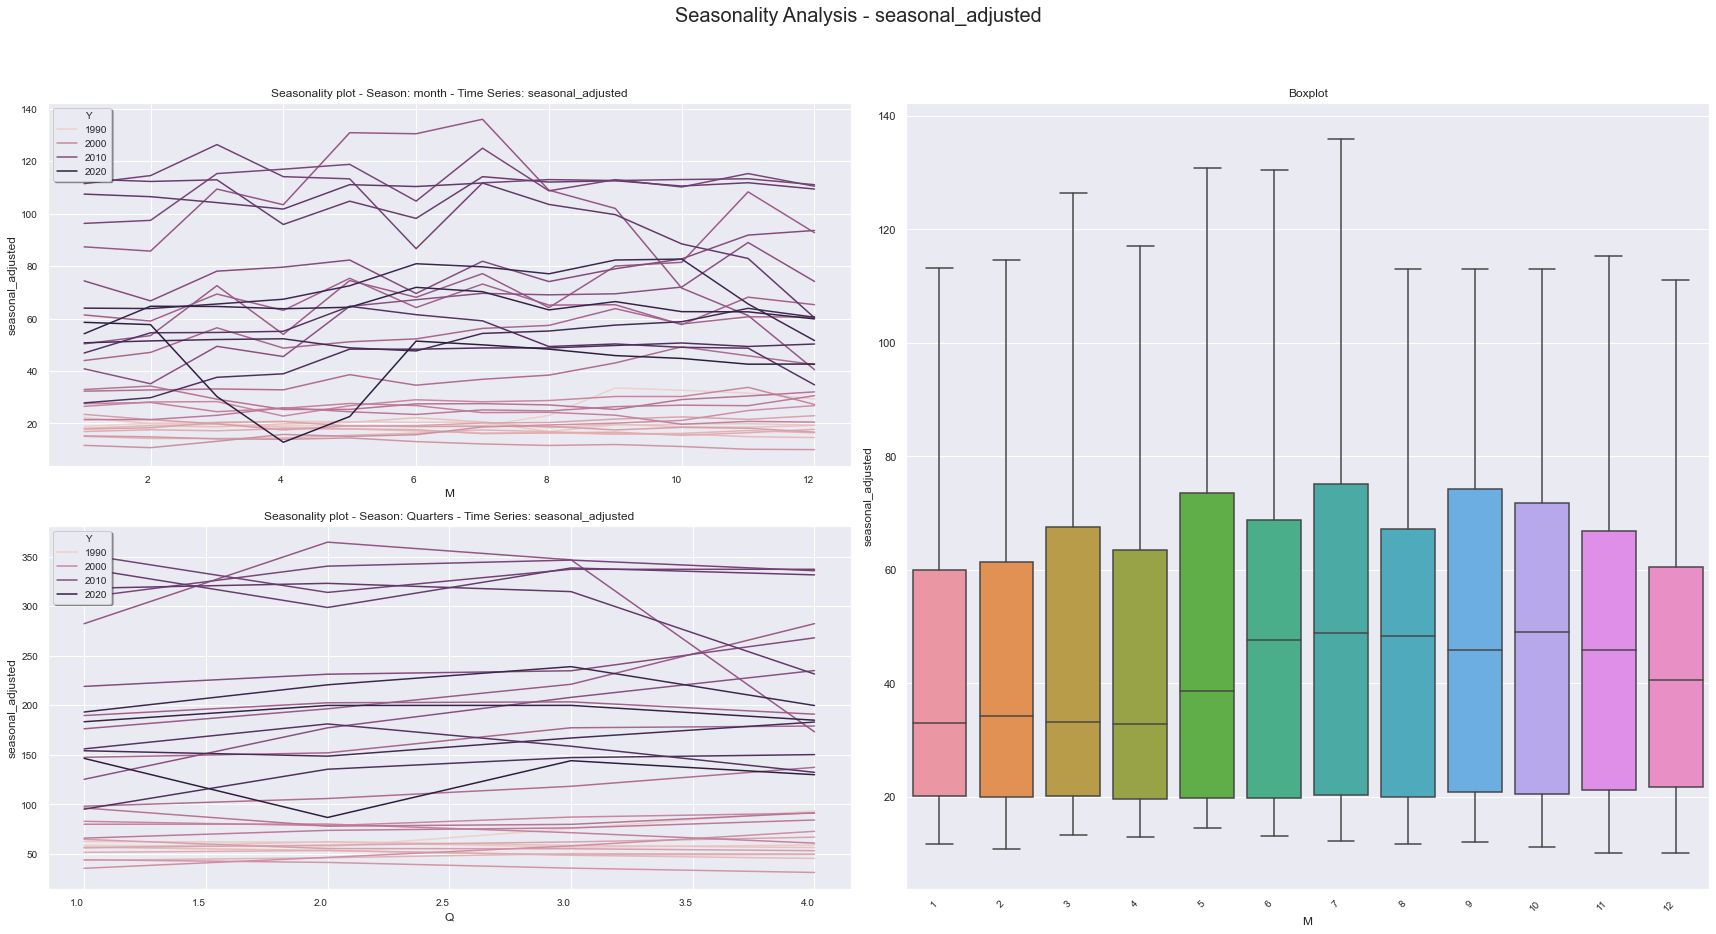

In [17]:
seasonality_plots(seasonal_adjusted, series='seasonal_adjusted', timestamp='index')

In [18]:
seasonal_adjusted

index  seasonal_adjusted     Y   M
0   1990-01-01          18.880595  1990   1
1   1990-02-01          20.080116  1990   2
2   1990-03-01          19.906017  1990   3
3   1990-04-01          19.174237  1990   4
4   1990-05-01          19.025673  1990   5
..         ...                ...   ...  ..
367 2020-08-01          48.325901  2020   8
368 2020-09-01          45.866349  2020   9
369 2020-10-01          44.781509  2020  10
370 2020-11-01          42.587784  2020  11
371 2020-12-01          42.650563  2020  12

[372 rows x 4 columns]

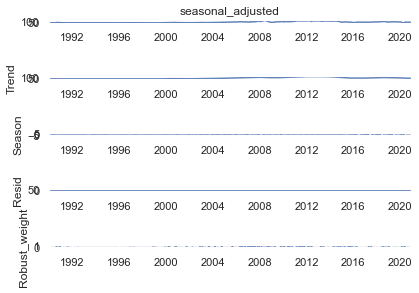

In [148]:
# BRENT OIL

period = 12

stl_dec_robust = STL(seasonal_adjusted.set_index('index').seasonal_adjusted, robust=True, period=period).fit()

stl_dec_robust.plot(weights=True)

#stl_dec.plot(weights=True)

plt.show()

## Testes de Estacionariedade

### ADF e KPSS

**Augmented Dickey Fuller Test - Testing For a Unit Root**

* A hipótese nula do ADF test é que existe uma raiz unitária (unit root), a hipótese alternativa é a não existência de uma raiz unitária.


**H0: Existe uma raiz unitária (não estacionária)**

**H1: Não existe uma raiz unitária**

* Resumo:

    * Se: O valor da estatística do teste é maior que o valores críticos (p_value greater than the critical size), então a hipótese nula não pode ser rejeitada, i.e, não pode-se rejeitar a hipótese que existe uma raiz unitária.

    * Se a hipótese nula não pode ser rejeita, isto é, existe uma raiz unitária, a série deve ser diferenciada para eliminação da raiz unitária i.e a série não é estacionária

**KPSS - Trend-Stationary Testing**

* A hipotése nula do Teste KPSS é que a série é estacionária. A hipótese alternativa é que a série não é estacionária.

**H0: Estacionariedade**

**H1: Existe uma raiz unitária**

* Resumo:
    * pvalues < critical_size => Hipótese nula deve ser rejeitada, a favor da hipótese alternativa


In [20]:
def stationary_test(series, test=None):
    def _adf(series, method='AIC'):
        adf_t = adfuller(series, autolag=method)
        
        result = {
            'test_statistic': adf_t[0],
            'pvalue': adf_t[1]
        }
        
        
        for k, v in adf_t[4].items():
            k = str(100 - int(k.replace('%',''))) + "%"
            result[f'Critical Value {k}'] = v
                
        return result
    
    def _kpss(series, regression='c'):
        kpss_t = kpss(series, regression=regression, nlags='auto')
        
        result = {
            'test_statistic': kpss_t[0],
            'pvalue': kpss_t[1],
            'lags': kpss_t[2]
        }
        
        #cv_dict = {}
        
        for k, v in kpss_t[3].items():
            k = str(int(100 - float(k.replace('%','')))) + "%"
            result[f'Critical Value {k}'] = v
        
        return result        
    
    if test == 'ADF':
        return _adf(series)
    elif test == 'KPSS':
        return _kpss(series)
    elif test == 'both':
        adf_t = _adf(series)
        kpss_t = _kpss(series)
        return {'ADF': adf_t, 'KPSS': kpss_t}
    else:
        raise ValueError(f'ValueError: test {test} is no available')

## COPPER STATIONARY TESTS

In [21]:
copper_stats = stationary_test(df.COPPER_USD_TON, 'both')

adf_ = pd.DataFrame(copper_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(copper_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF       KPSS
test_statistic     -1.147458   2.203058
pvalue              0.695780   0.010000
Critical Value 99% -3.448749   0.739000
Critical Value 95% -2.869647   0.463000
Critical Value 90% -2.571089   0.347000
lags                     NaN  11.000000
Critical Value 97%       NaN   0.574000

#### RESULTADOS

**alfa = 0.05**

##### ADF:
- Test Stat > CV(0.05): -1.15 > -2.87
- p-value > 0.05: 0.695 > 0.05
    - Resultado: Hipótese Nula não pode ser rejeitada - Existe uma raiz unitária (Ñ-Est)

##### KPSS:
- Test Stat > CV: 2.20 > 0.46 
- p-value < 0.05: 0.01 < 0.05
    - Resultado: Existem evidências para rejeitar a hipótese nula (p-value < 0.05), em favor da hipótese alternativa; a série não é estacionária
    
#### RESULTADO: 

**A série NÃO É ESTACIONÁRIA**

- ADF: Existe uma raiz unitária, a série deve ser diferenciada para remoção da raiz unitária.
- KPSS: Existe uma raiz estacionária (não estacionária)


In [22]:
cooper_diff = df.COPPER_USD_TON.diff(1)

copper_diff_stats = stationary_test(cooper_diff.dropna(), 'both')

adf_ = pd.DataFrame(copper_diff_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(copper_diff_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



ADF      KPSS
test_statistic     -5.718914e+00  0.050277
pvalue              7.015145e-07  0.100000
Critical Value 99% -3.448749e+00  0.739000
Critical Value 95% -2.869647e+00  0.463000
Critical Value 90% -2.571089e+00  0.347000
lags                         NaN  5.000000
Critical Value 97%           NaN  0.574000

#### RESULTADOS

**alfa = 0.05**

##### ADF:
- Test Stat < CV(0.05): -5.72 < -2.87
- p-value < 0.05: 7e-7 << 0.05
    - Resultado: Hipótese Nula deve ser rejeitada em favor da hipótese alternativa - Não Existe uma raiz unitária

##### KPSS:
- Test Stat < CV: 0.05 < 0.46 
- p-value < 0.05: 0.1 > 0.05
    - Resultado: Existem evidências para não rejeitar a hipótese nula (p-value > 0.05); a série é estacionária
    
#### RESULTADO: 

**A série É ESTACIONÁRIA**

- ADF: Não Existe uma raiz unitária.
- KPSS: A série é estacionária

## ACF and PACF - Correlogramas

- "**When data have a trend, the autocorrelations for small lags tend to be large and positive** because observations nearby in time are also nearby in size. So **the ACF of trended time series tend to have positive values that slowly decrease as the lags increase**. **When data are seasonal, the autocorrelations will be larger for the seasonal lags** (at multiples of the seasonal frequency) than for other lags." [Hyndman et al., Forecasting Principles and Practice](https://otexts.com/fpp2/autocorrelation.html)

Confidence interval: [0.10162126608358167, -0.10162126608358167]


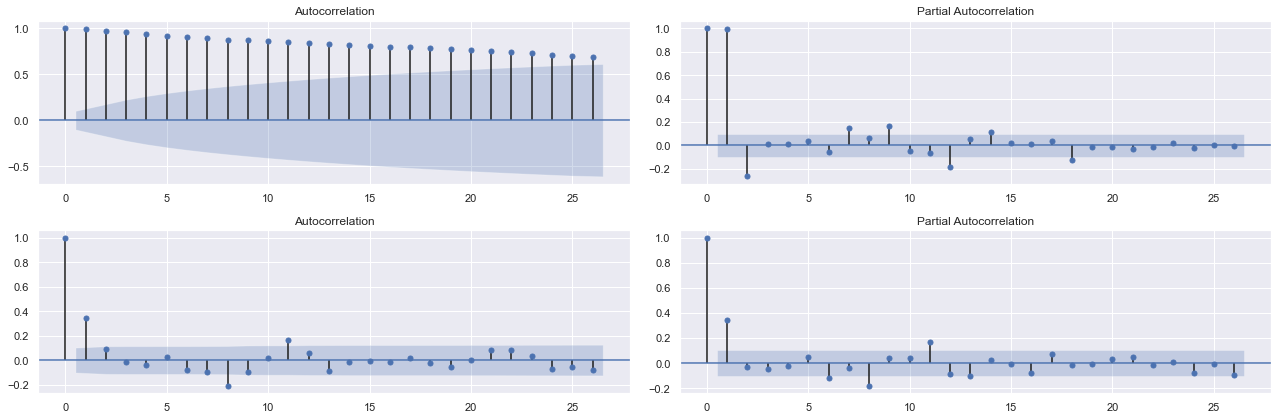

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_copper = df.COPPER_USD_TON

ts_copper_diff = df.COPPER_USD_TON.diff().dropna()

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(18,6))
axs = axs.ravel()

ci = [c*(1.96 / np.sqrt(len(ts_copper))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(ts_copper, ax=axs[0])

plot_pacf(ts_copper, ax=axs[1])

plot_acf(ts_copper_diff, ax=axs[2])

plot_pacf(ts_copper_diff, ax=axs[3])

plt.tight_layout()
plt.show()

**Série Diferenciada**
- ACF: rk ~ 0 p/ k >= 1 => MA(1)
- PACF: rk ~ 0 p/ k >= 1 => AR(1)


## BRENT OIL STATIONARY TESTS

In [24]:
oil_stats = stationary_test(df.BRENT_OIL_USD_BLL, 'both')

adf_ = pd.DataFrame(oil_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(oil_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



ADF      KPSS
test_statistic     -2.274949   1.93975
pvalue              0.180175   0.01000
Critical Value 99% -3.448148   0.73900
Critical Value 95% -2.869383   0.46300
Critical Value 90% -2.570948   0.34700
lags                     NaN  11.00000
Critical Value 97%       NaN   0.57400

#### RESULTADOS

**alfa = 0.05**

##### ADF:
- Test Stat > CV(0.05): -2.27 > -2.870
- p-value > alfa: 0.180 > 0.05
    - Resultado: Hipótese nula não pode ser rejeitada; Existe uma raiz unitária, a série deve ser diferenciada, para remoção da raiz unitária.

##### KPSS:
- Test Stat < CV: 1.939 > 0.463 
- p-value < alfa: 0.01 < 0.05
    - Resultado: Existem evidências para rejeitar a hipótese nula (p-value < 0.05); Existe uma raiz unitária.
    
#### RESULTADO: 

**A série NÃO É ESTACIONÁRIA**

- ADF: Existe uma raiz unitária.
- KPSS: Existe uma raiz unitária.

In [25]:
oil_diff = df.BRENT_OIL_USD_BLL.diff(1)

oil_diff_stats = stationary_test(oil_diff.dropna(), 'both')

adf_ = pd.DataFrame(oil_diff_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(oil_diff_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



ADF      KPSS
test_statistic     -1.260028e+01  0.065774
pvalue              1.742324e-23  0.100000
Critical Value 99% -3.448148e+00  0.739000
Critical Value 95% -2.869383e+00  0.463000
Critical Value 90% -2.570948e+00  0.347000
lags                         NaN  4.000000
Critical Value 97%           NaN  0.574000

#### RESULTADOS

**alfa = 0.05**

##### ADF:
- Test Stat < CV(0.05): 1.26 < -2.87
- p-value < 0.05: 1.74e-23 << 0.05
    - Resultado: Hipótese Nula deve ser rejeitada em favor da hipótese alternativa - Não Existe uma raiz unitária

##### KPSS:
- Test Stat < CV: 0.065 < 0.46 
- p-value < 0.05: 0.1 > 0.05
    - Resultado: Existem evidências para não rejeitar a hipótese nula (p-value > 0.05); a série é estacionária
    
#### RESULTADO: 

**A série É ESTACIONÁRIA**

- ADF: Não Existe uma raiz unitária.
- KPSS: A série é estacionária

## ACF and PACF - Correlogramas

Confidence interval: [0.10162126608358167, -0.10162126608358167]


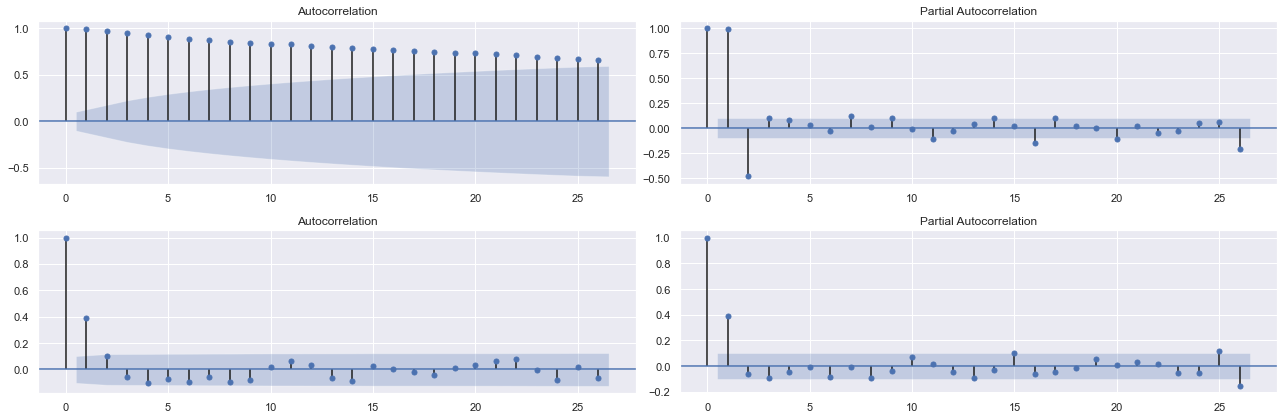

In [26]:
ts_oil = df.BRENT_OIL_USD_BLL

ts_oil_diff = df.BRENT_OIL_USD_BLL.diff().dropna()

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(18,6))
axs = axs.ravel()

ci = [c*(1.96 / np.sqrt(len(ts_oil))) for c in [1, -1]]

print(f"Confidence interval: {ci}")

plot_acf(ts_oil, ax=axs[0])

plot_pacf(ts_oil, ax=axs[1])

plot_acf(ts_oil_diff, ax=axs[2])

plot_pacf(ts_oil_diff, ax=axs[3])

plt.tight_layout()
plt.show()

**Série Diferenciada**
- ACF: rk ~ 0 p/ k >= 1 => MA(1)
- PACF: rk ~ 0 p/ k >= 1 => AR(1)


# Model Building - ARIMA(p,0,q)

**Assumptions**



In [27]:
from IPython.display import display, HTML

css = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(css))

In [63]:
def optmize_ARIMA(ts, order:tuple):
    
    p,d,q = order

    model_selection = []

    aic_matrix = []
    bic_matrix = []

    for p in range(p+1):
        aic_tmp = []
        bic_tmp = []

        for q in range(q+1):
            model = ARIMA(ts, order=(p, d, q))
            results = model.fit()
            model_selection.append((p,q, results.aic, results.bic))
            aic_tmp.append(results.aic)
            bic_tmp.append(results.bic)

        aic_matrix.append(aic_tmp)
        bic_matrix.append(bic_tmp)

    aic_matrix = np.matrix(aic_matrix).reshape(p+1,q+1)
    bic_matrix = np.matrix(bic_matrix).reshape(p+1,q+1)
    model_selection = pd.DataFrame(model_selection, columns=['p','q', 'aic', 'bic'])
    
    return aic_matrix, bic_matrix, model_selection

In [142]:
def mae(residuals):
    return np.mean(np.abs(residuals))

def mape(y, yhat):
    abs_diff = np.abs(y-yhat)
    ape = abs_diff/np.abs(y)
    ape[ape == np.inf] = 0
    ape[ape == np.nan] = 0 
    return np.mean(ape)*100

## COPPER ENTIRE DATASET

### MODEL BUILDING ENTIRE DATASET

- Avaliar o poder preditivo do ARIMA: Modelar todo o dataset utilizando o ARIMA com mínimos AIC e BIC;
- Avaliar a validade do modelo - Resíduos i.i.d;

- MAE e MAPE

In [128]:
%%time
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

ts = df.COPPER_USD_TON.asfreq('MS')[:]
ts_diff = df.COPPER_USD_TON.diff().asfreq('MS')[:]

intg_order = (3,1,3)
diff_order = (3,0,3)

intg_aic_mtx, intg_bic_mtx, intg_model_selection = optmize_ARIMA(ts, intg_order)
diff_aic_mtx, diff_bic_mtx, diff_model_selection = optmize_ARIMA(ts_diff, diff_order)



print("\nIntegrated Series Minimum AIC")
print(f"Minimum AIC: {intg_aic_mtx.min()}")
#display(pd.DataFrame(aic_matrix))
display(intg_model_selection.loc[intg_model_selection.aic==intg_model_selection.aic.min()])

print("\nIntegrated Series Minimum BIC")
print(f"Minimum BIC: {intg_bic_mtx.min()}")
#display(pd.DataFrame(bic_matrix))
display(intg_model_selection.loc[intg_model_selection.bic==intg_model_selection.bic.min()])

print("\nDifferenciated Series Minimum AIC")
print(f"Minimum AIC: {diff_aic_mtx.min()}")
#display(pd.DataFrame(aic_matrix))
display(diff_model_selection.loc[diff_model_selection.aic==diff_model_selection.aic.min()])

print("\nDifferenciated Series Minimum BIC")
print(f"Minimum BIC: {diff_bic_mtx.min()}")
#display(pd.DataFrame(bic_matrix))
display(diff_model_selection.loc[diff_model_selection.bic==diff_model_selection.bic.min()])


Integrated Series Minimum AIC
Minimum AIC: 5286.425174930233


p  q          aic          bic
11  2  3  5286.425175  5309.922387


Integrated Series Minimum BIC
Minimum BIC: 5297.771110136948


p  q          aic         bic
4  1  0  5289.938706  5297.77111


Differenciated Series Minimum AIC
Minimum AIC: 5287.918955173693


p  q          aic          bic
14  3  2  5287.918955  5315.351212


Differenciated Series Minimum BIC
Minimum BIC: 5303.2143623831735


p  q          aic          bic
4  1  0  5291.457681  5303.214362

Wall time: 7.72 s


p  q          aic          bic
11  2  1  5290.853857  5306.518665
12  1  0  5289.938706  5297.771110
13  3  2  5289.059980  5312.557192
14  3  3  5288.207807  5315.621222
15  2  3  5286.425175  5309.922387

p  q          aic          bic
11  1  1  5291.772308  5303.520914
12  2  0  5291.715917  5303.464523
13  0  2  5291.300143  5303.048749
14  0  1  5293.680953  5301.513357
15  1  0  5289.938706  5297.771110

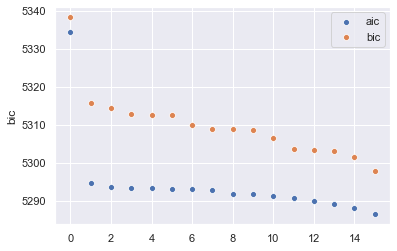

In [129]:
sns.scatterplot(data = intg_model_selection.sort_values('aic', ascending=False).reset_index(drop=True),
        x=intg_model_selection.sort_values('aic', ascending=False).reset_index(drop=True).index,
        y='aic', label='aic')

sns.scatterplot(data = intg_model_selection.sort_values('bic', ascending=False).reset_index(drop=True),
        x=intg_model_selection.sort_values('bic', ascending=False).reset_index(drop=True).index,
        y='bic', label='bic')

display(intg_model_selection.sort_values('aic', ascending=False).reset_index(drop=True).tail())
display(intg_model_selection.sort_values('bic', ascending=False).reset_index(drop=True).tail())

p  q          aic          bic
11  1  0  5291.457681  5303.214362
12  2  1  5290.200023  5309.794492
13  3  3  5289.422125  5320.773276
14  2  3  5288.018896  5315.451153
15  3  2  5287.918955  5315.351212

p  q          aic          bic
11  1  1  5293.255527  5308.931103
12  2  0  5293.189137  5308.864713
13  0  2  5292.784849  5308.460424
14  0  1  5294.994791  5306.751472
15  1  0  5291.457681  5303.214362

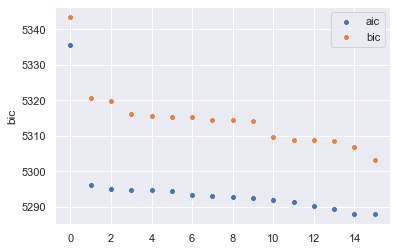

In [132]:
sns.scatterplot(data = diff_model_selection.sort_values('aic', ascending=False).reset_index(drop=True),
        x=diff_model_selection.sort_values('aic', ascending=False).reset_index(drop=True).index,
        y='aic', label='aic')

sns.scatterplot(data = diff_model_selection.sort_values('bic', ascending=False).reset_index(drop=True),
        x=diff_model_selection.sort_values('bic', ascending=False).reset_index(drop=True).index,
        y='bic', label='bic')

display(diff_model_selection.sort_values('aic', ascending=False).reset_index(drop=True).tail())
display(diff_model_selection.sort_values('bic', ascending=False).reset_index(drop=True).tail())

###### MODEL DIAGNOSTICS

**BASED ON AIC AND BIC**
 


#### Original Series Model Diagnostics

ARIMA(2, 1, 3) MAE: 192.9267176158814
ARIMA(2, 1, 3) MAPE: 4.419455138553894
ARIMA(1, 1, 0) MAE: 192.29737471431065
ARIMA(1, 1, 0) MAPE: 4.34057065516382


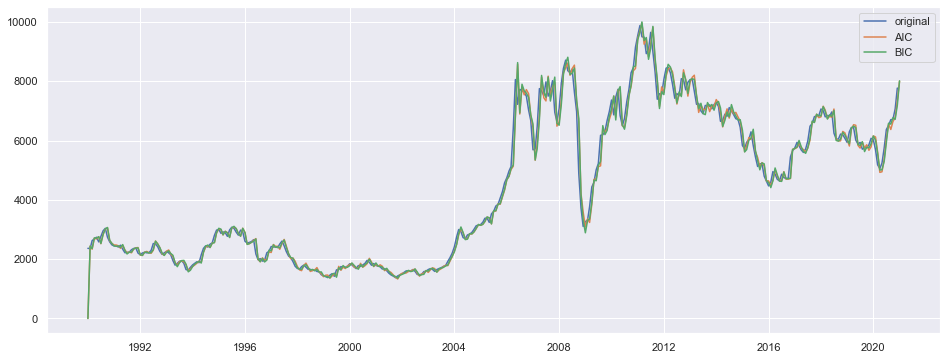

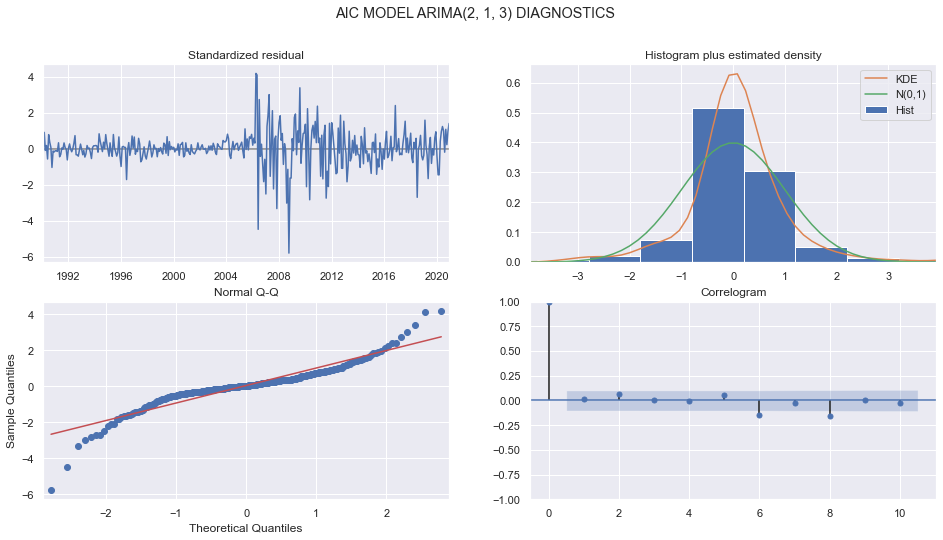

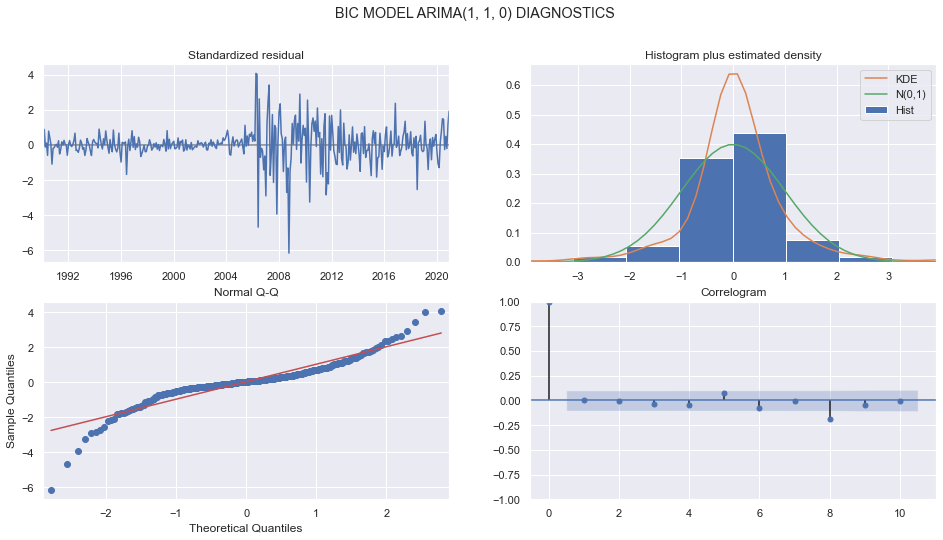

Wall time: 2.55 s


In [130]:
%%time
from statsmodels.stats.diagnostic import acorr_ljungbox

#ts = df.COPPER_USD_TON.asfreq('MS') #ts_copper_diff.asfreq('MS')[:]

### Original Series Model Diagnostics

aic_order = (2,1,3)

bic_order = (1,1,0)

model_aic = ARIMA(ts, order=aic_order)
results_aic = model_aic.fit()

model_bic = ARIMA(ts, order=bic_order)
results_bic = model_bic.fit()


print(f"ARIMA{aic_order} MAE: {mae(results_aic.resid)}")
print(f"ARIMA{aic_order} MAPE: {mape(ts, results_aic.fittedvalues)}")

print(f"ARIMA{bic_order} MAE: {mae(results_bic.resid)}")
print(f"ARIMA{bic_order} MAPE: {mape(ts, results_bic.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(ts, label='original')
plt.plot(results_aic.predict(start=0, end=len(ts)), label='AIC')
plt.plot(results_bic.predict(start=0, end=len(ts)), label='BIC')

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC MODEL ARIMA{aic_order} DIAGNOSTICS")

results_aic.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

fig2 = plt.figure(figsize=(16,8))
fig2.suptitle(f"BIC MODEL ARIMA{bic_order} DIAGNOSTICS")

results_bic.plot_diagnostics(fig=fig2)
#print(acorr_ljungbox(results_bic.resid,  lags=[10], return_df=True))
plt.show()

#### Diff Series Model Diagnostics

ARIMA(3, 0, 2) MAE: 189.53600533131436
ARIMA(3, 0, 2) MAPE: inf
ARIMA(1, 0, 0) MAE: 185.76882869281897
ARIMA(1, 0, 0) MAPE: inf


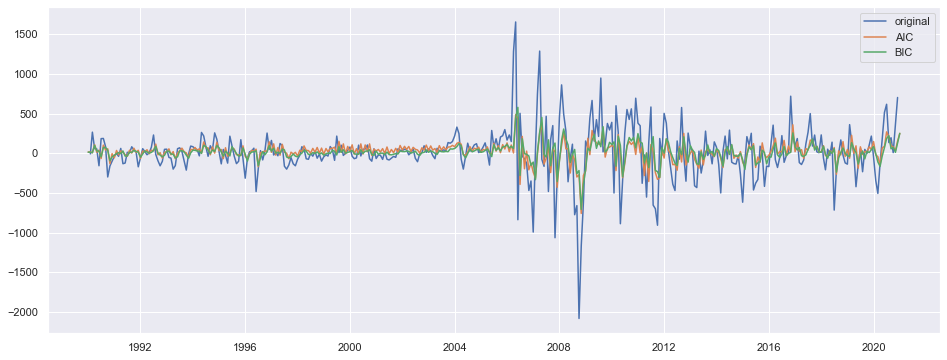

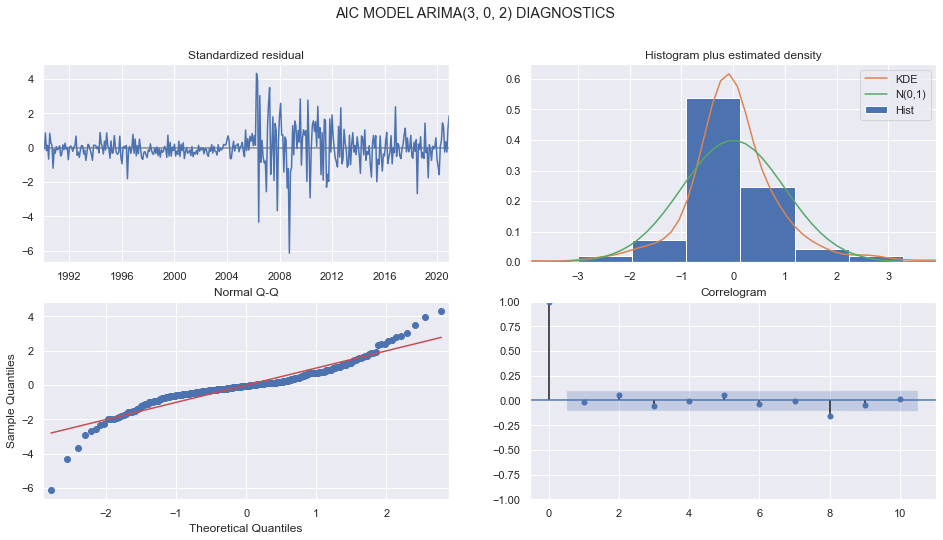

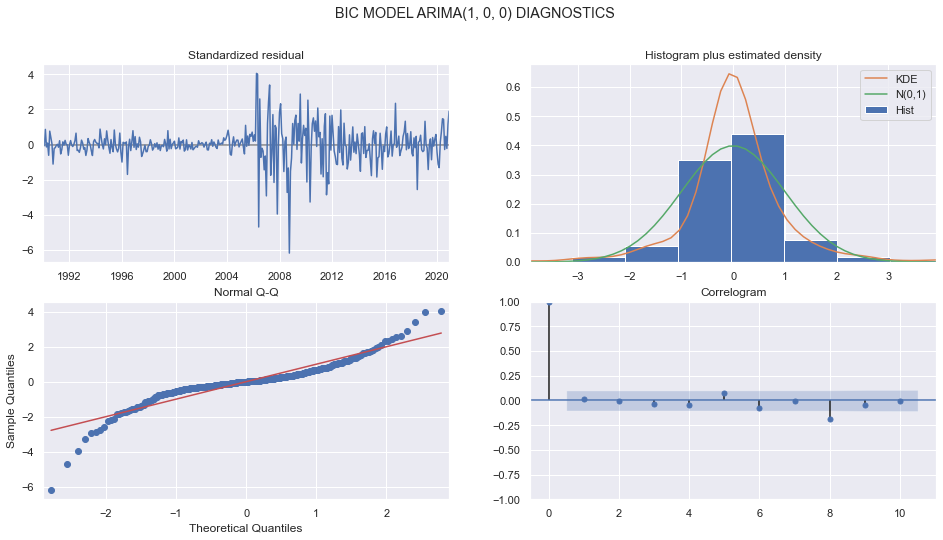

Wall time: 2.71 s


In [133]:
%%time

#ts_diff = df.COPPER_USD_TON.asfreq('MS') #ts_diff_copper_diff.asfreq('MS')[:]

### Diff Series Model Diagnostics

aic_order = (3,0,2)

bic_order = (1,0,0)

model_aic = ARIMA(ts_diff, order=aic_order)
results_diff_aic = model_aic.fit()

model_bic = ARIMA(ts_diff, order=bic_order)
results_diff_bic = model_bic.fit()


print(f"ARIMA{aic_order} MAE: {mae(results_diff_aic.resid)}")
print(f"ARIMA{aic_order} MAPE: {mape(ts_diff, results_diff_aic.fittedvalues)}")

print(f"ARIMA{bic_order} MAE: {mae(results_diff_bic.resid)}")
print(f"ARIMA{bic_order} MAPE: {mape(ts_diff, results_diff_bic.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(ts_diff, label='original')
plt.plot(results_diff_aic.predict(start=0, end=len(ts_diff)), label='AIC')
plt.plot(results_diff_bic.predict(start=0, end=len(ts_diff)), label='BIC')

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC MODEL ARIMA{aic_order} DIAGNOSTICS")

results_diff_aic.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_diff_aic.resid,  lags=[10], return_df=True))

fig2 = plt.figure(figsize=(16,8))
fig2.suptitle(f"BIC MODEL ARIMA{bic_order} DIAGNOSTICS")

results_diff_bic.plot_diagnostics(fig=fig2)
#print(acorr_ljungbox(results_diff_bic.resid,  lags=[10], return_df=True))
plt.show()

### FORECASTING 

#### FORECASTING WITH THE ORIGINAL SERIES - ARIMA(p,q,d)

##### MODEL FITTING AND DIAGNOSTICS

Train size: 297
Test size: 75
ARIMA(2, 1, 3) MAE: 192.98242545976078
ARIMA(2, 1, 3) MAPE: 4.745865260762512


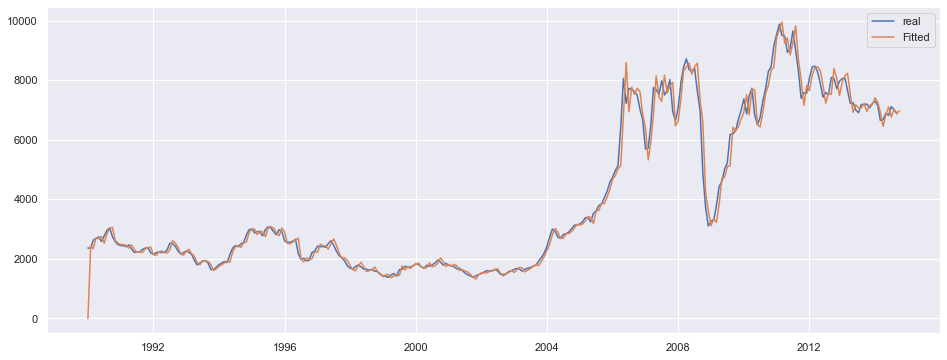

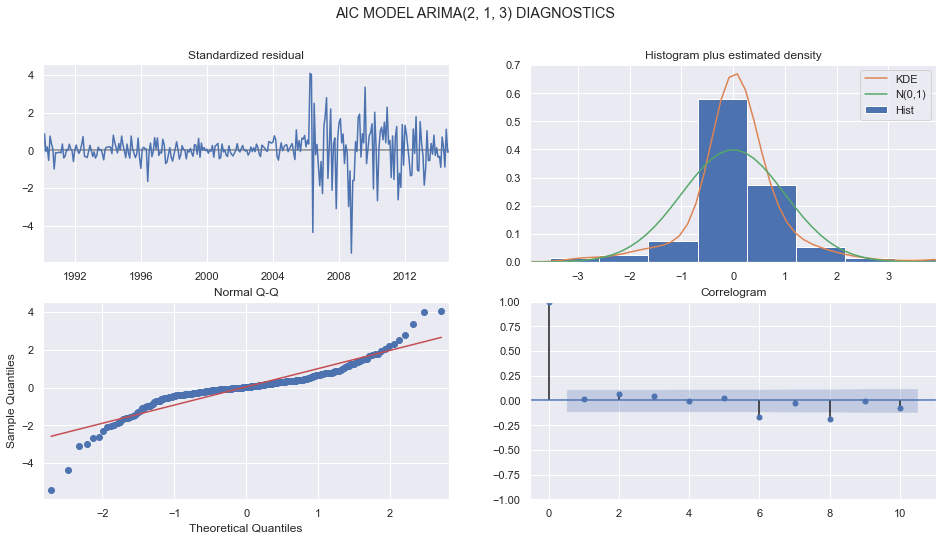

In [134]:
split = int(0.8*len(ts))

history = df.COPPER_USD_TON.asfreq('MS')[:]

train = history[:split]
test = history[split:]

model_order = (2,1,3) # Least MAPE and Least ACF 

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

model = ARIMA(train, order=model_order, trend='c')
results = model.fit()

print(f"ARIMA{model_order} MAE: {mae(results.resid)}")
print(f"ARIMA{model_order} MAPE: {mape(train, results.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='real')
plt.plot(results.predict(start=0, end=len(train)), label='Fitted')

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC MODEL ARIMA{model_order} DIAGNOSTICS")

results.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

plt.show()

##### FORECASTING

ARIMA(2, 1, 3) MAE: 1131.707971948884
ARIMA(2, 1, 3) MAPE: 16.138108790487323


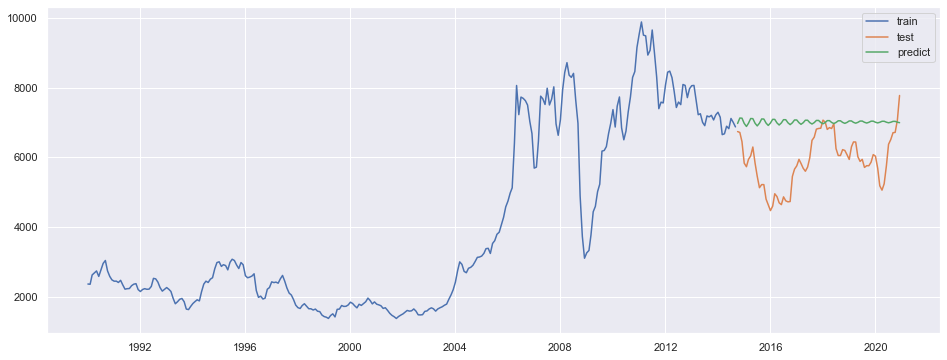

In [135]:
pred = results.predict(start=test.index[0], end=test.index[len(test)-1])

residuals = pred - test

print(f"ARIMA{model_order} MAE: {mae(residuals)}")
print(f"ARIMA{model_order} MAPE: {mape(pred, test)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predict')

plt.legend(loc='best')

#### FORECASTING WITH THE DIFF SERIES - ARMA(p,q)

Train size: 297
Test size: 75
ARIMA(1, 0, 0) MAE: 185.46200315062404
ARIMA(1, 0, 0) MAPE: 134.8032807932507


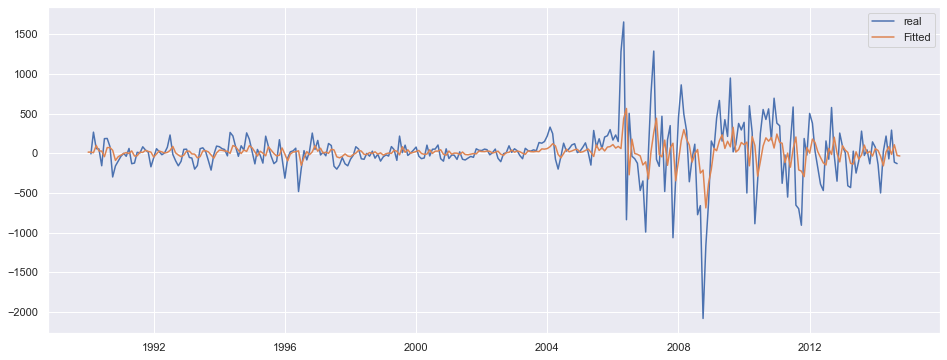

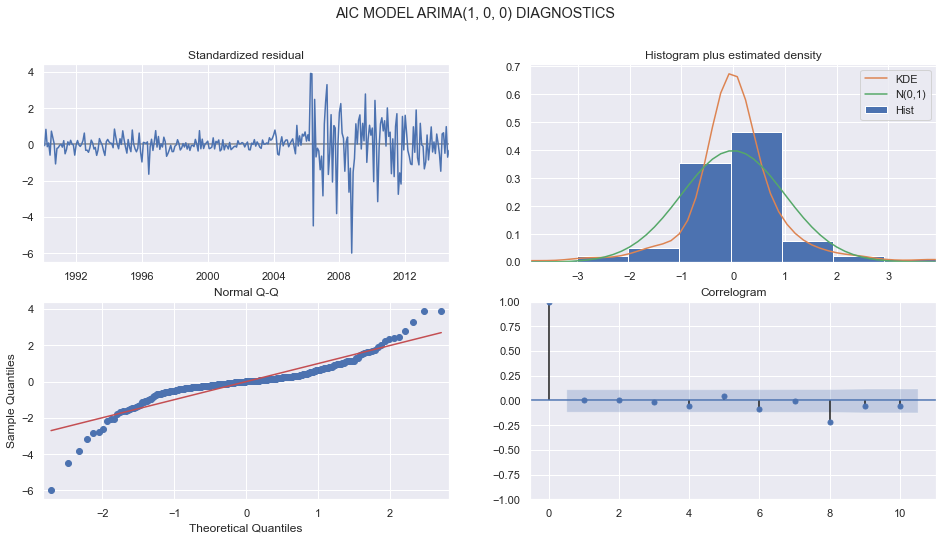

In [144]:
split = int(0.8*len(ts))

history = df.COPPER_USD_TON.diff().asfreq('MS')[:]

train = history[:split]
test = history[split:]

model_order = (1,0,0) # Least MAPE and Least ACF 

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

model = ARIMA(train, order=model_order, trend='c')
results = model.fit()

print(f"ARIMA{model_order} MAE: {mae(results.resid)}")
print(f"ARIMA{model_order} MAPE: {mape(train, results.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='real')
plt.plot(results.predict(start=0, end=len(train)), label='Fitted')

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC MODEL ARIMA{model_order} DIAGNOSTICS")

results.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

plt.show()

In [145]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         COPPER_USD_TON   No. Observations:                  297
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2119.317
Date:                Sun, 17 Jan 2021   AIC                           4244.633
Time:                        19:46:02   BIC                           4255.714
Sample:                    01-01-1990   HQIC                          4249.069
                         - 09-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.2251     28.820      0.528      0.597     -41.261      71.712
ar.L1          0.3353      0.026     12.672      0.000       0.283       0.387
sigma2      9.722e+04   3771.413     25.779      0.000    8.98e+04    1.05e+05
===================================================================================
Ljung-Box (Q):                       74.09   Jarque-Bera (JB):               804.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.82   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA(1, 0, 0) MAE: 202.4547728773844
ARIMA(1, 0, 0) MAPE: 1374.3494010840554


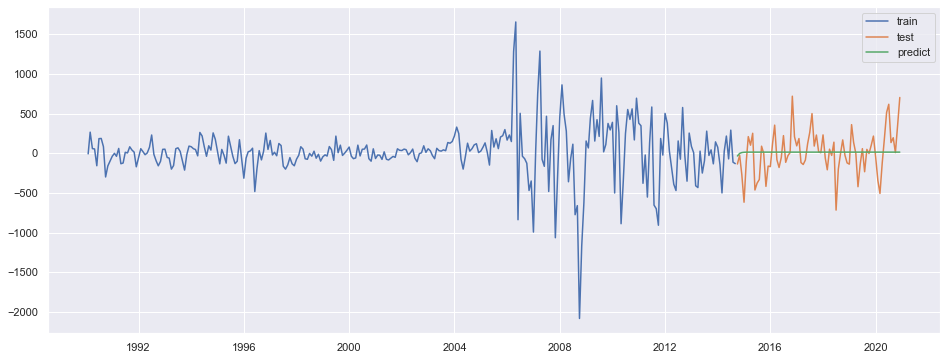

In [146]:
pred = results.predict(start=test.index[0], end=test.index[len(test)-1])

residuals = pred - test

print(f"ARIMA{model_order} MAE: {mae(residuals)}")
print(f"ARIMA{model_order} MAPE: {mape(pred, test)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predict')

plt.legend(loc='best')

## COPPER SPLIT DATASET IN TWO DOMAINS

In [149]:
Fig = go.Figure()

Fig.add_trace(go.Scatter(x=df.COPPER_USD_TON[:].diff().index,
                        y=df.COPPER_USD_TON[:].diff()))


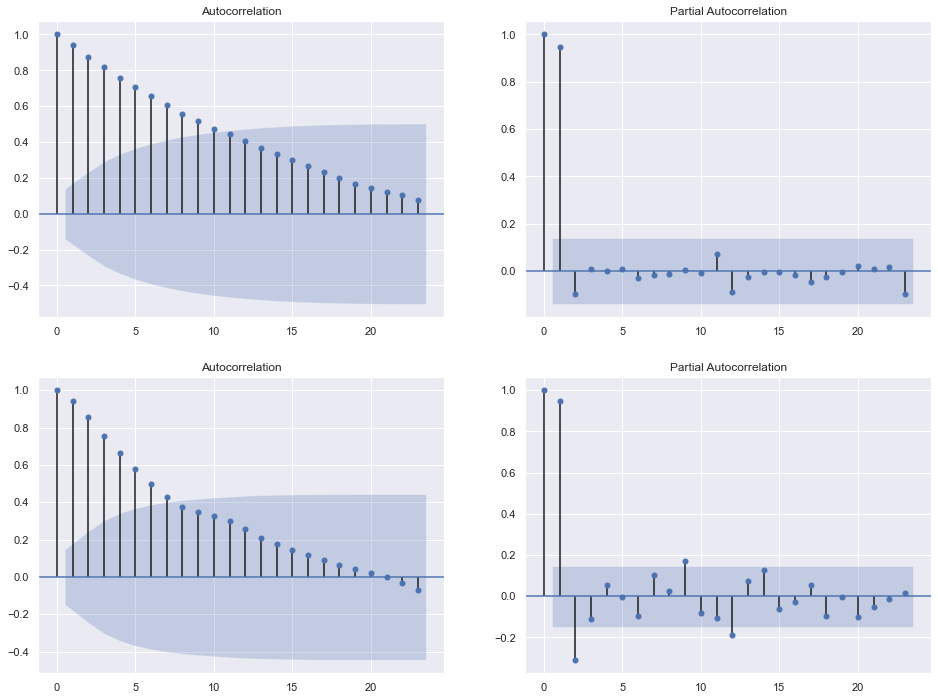

In [163]:
domain = dt.date(2006,3,1)
history1 = df.COPPER_USD_TON[:domain]
history2 = df.COPPER_USD_TON[domain:][1:]

fig, ax = plt.subplots(2,2, figsize=(16,12))
ax = ax.ravel()

plot_acf(history1, ax=ax[0])
plot_pacf(history1, ax=ax[1])

plot_acf(history2, ax=ax[2])
plot_pacf(history2, ax=ax[3])

plt.show()

display()

In [158]:
h1_stats = stationary_test(history1, 'both')

adf_ = pd.DataFrame(h1_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(h1_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



ADF      KPSS
test_statistic      0.886889  0.269231
pvalue              0.992917  0.100000
Critical Value 99% -3.464694  0.739000
Critical Value 95% -2.876635  0.463000
Critical Value 90% -2.574816  0.347000
lags                     NaN  9.000000
Critical Value 97%       NaN  0.574000

In [160]:
h2_stats = stationary_test(history2, 'both')

adf_ = pd.DataFrame(h2_stats['ADF'], index=['ADF'])
kpss_ = pd.DataFrame(h2_stats['KPSS'], index=['KPSS'])

results = pd.concat([adf_, kpss_])
results.T

ADF      KPSS
test_statistic     -3.080716  0.436949
pvalue              0.028014  0.061229
Critical Value 99% -3.468280  0.739000
Critical Value 95% -2.878202  0.463000
Critical Value 90% -2.575653  0.347000
lags                     NaN  8.000000
Critical Value 97%       NaN  0.574000

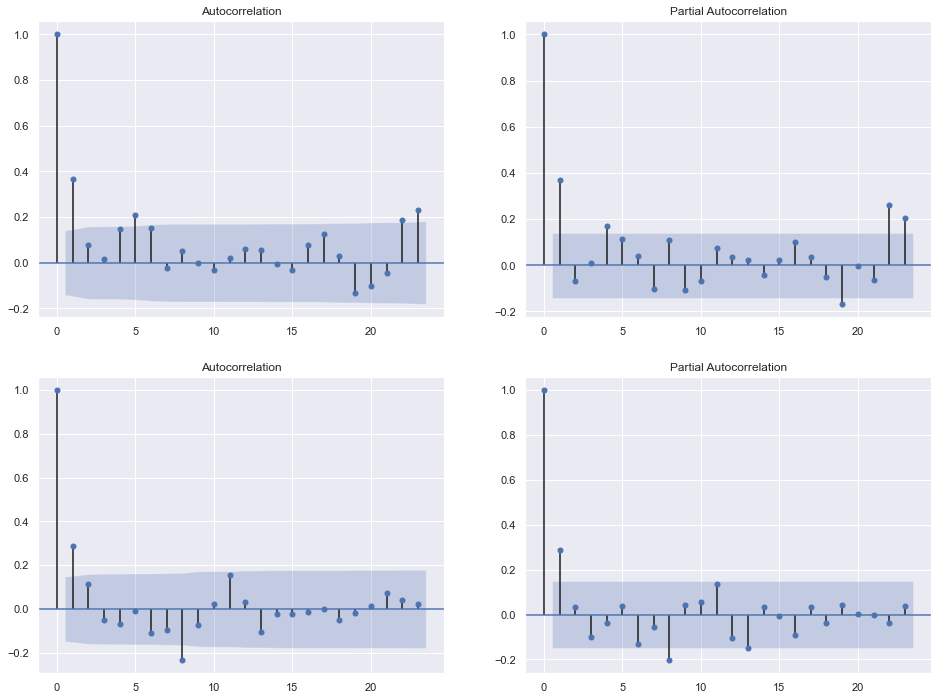

In [164]:
h1_diff = history1.diff().dropna()
h2_diff = history2.diff().dropna()

fig, ax = plt.subplots(2,2, figsize=(16,12))
ax = ax.ravel()

plot_acf(h1_diff, ax=ax[0])
plot_pacf(h1_diff, ax=ax[1])


plot_acf(h2_diff, ax=ax[2])
plot_pacf(h2_diff, ax=ax[3])

plt.show()

In [166]:
optmize_ARIMA(h1_diff.asfreq('MS'), (2,0,2))

(matrix([[2407.68599267, 2382.33846796, 2381.9185095 ],
         [2381.29749597, 2382.50722812, 2381.95592624],
         [2382.41818145, 2384.41247124, 2383.75096335]]),
 matrix([[2414.22170899, 2392.14204244, 2394.98994214],
         [2391.10107045, 2395.57866075, 2398.29521704],
         [2395.48961408, 2400.75176203, 2403.3581123 ]]),
    p  q          aic          bic
 0  0  0  2407.685993  2414.221709
 1  0  1  2382.338468  2392.142042
 2  0  2  2381.918510  2394.989942
 3  1  0  2381.297496  2391.101070
 4  1  1  2382.507228  2395.578661
 5  1  2  2381.955926  2398.295217
 6  2  0  2382.418181  2395.489614
 7  2  1  2384.412471  2400.751762
 8  2  2  2383.750963  2403.358112)

In [167]:
optmize_ARIMA(h2_diff.asfreq('MS'), (2,0,2))

(matrix([[2643.13014605, 2630.77249304, 2628.87912972],
         [2628.42099506, 2630.4090823 , 2630.77356595],
         [2630.39347326, 2628.49962511, 2631.76922522]]),
 matrix([[2649.47111404, 2640.28394502, 2641.5610657 ],
         [2637.93244705, 2643.09101828, 2646.62598592],
         [2643.07540924, 2644.35204508, 2650.79212919]]),
    p  q          aic          bic
 0  0  0  2643.130146  2649.471114
 1  0  1  2630.772493  2640.283945
 2  0  2  2628.879130  2641.561066
 3  1  0  2628.420995  2637.932447
 4  1  1  2630.409082  2643.091018
 5  1  2  2630.773566  2646.625986
 6  2  0  2630.393473  2643.075409
 7  2  1  2628.499625  2644.352045
 8  2  2  2631.769225  2650.792129)

### Forecasting The first Domain (Cycle ??)

MAE: 80.88773836734651


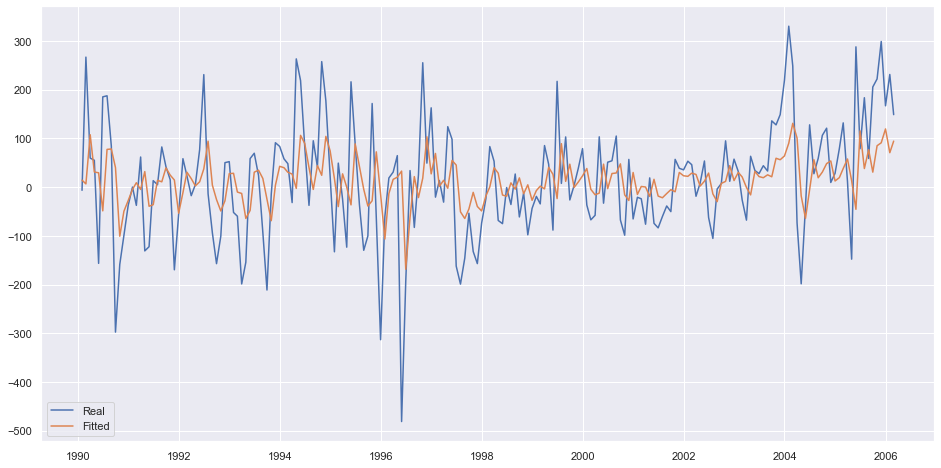

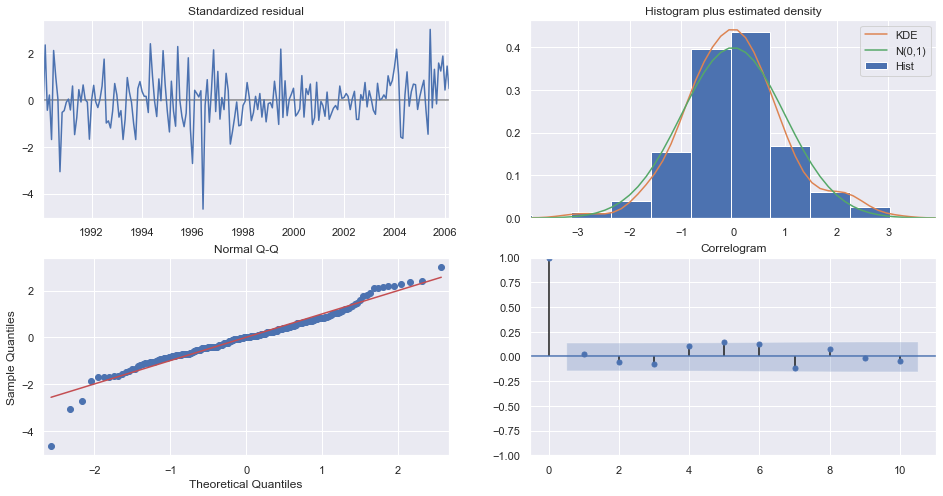

In [179]:
h1_model = ARIMA(h1_diff.asfreq('MS'), order=(1,0,0))
h1_results = h1_model.fit()

fig = plt.figure(figsize=(16,8))

plt.plot(h1_diff, label='Real')
plt.plot(h1_results.fittedvalues, label='Fitted')
plt.legend(loc='lower left')

h1_results.plot_diagnostics(figsize=(16,8))

print(f'MAE: {mae(h1_results.resid)}')

#### Forecasting 

Train size: 155
Test size: 39
ARIMA(1, 0, 0) MAE: 78.44451316999995
ARIMA(1, 0, 0) MAPE: 126.69937268391176


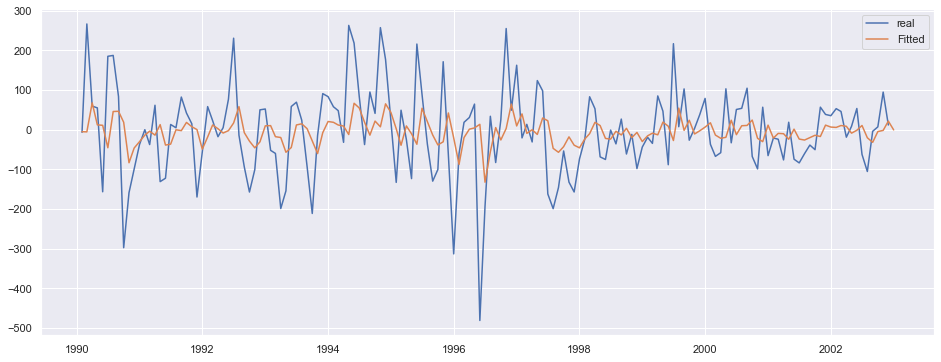

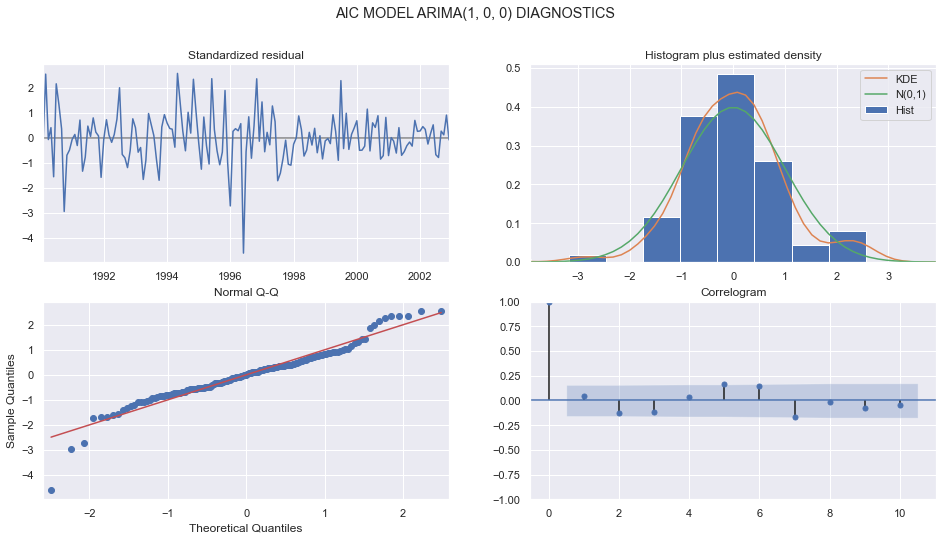

In [181]:

split = int(0.8*len(h1_diff))

train = h1_diff.asfreq("MS")[:split]
test = h1_diff.asfreq("MS")[split:]

model_order = (1,0,0) # Least MAPE and Least ACF 

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

model = ARIMA(train, order=model_order, trend='c')
results = model.fit()

print(f"ARIMA{model_order} MAE: {mae(results.resid)}")
print(f"ARIMA{model_order} MAPE: {mape(train, results.fittedvalues)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='real')
plt.plot(results.predict(start=0, end=len(train)), label='Fitted')

plt.legend(loc='best')

fig1 = plt.figure(figsize=(16,8))
fig1.suptitle(f"AIC MODEL ARIMA{model_order} DIAGNOSTICS")

results.plot_diagnostics(fig=fig1)
#print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

plt.show()

ARIMA(1, 0, 0) MAE: 122.21783223708
ARIMA(1, 0, 0) MAPE: 2761.748417525154


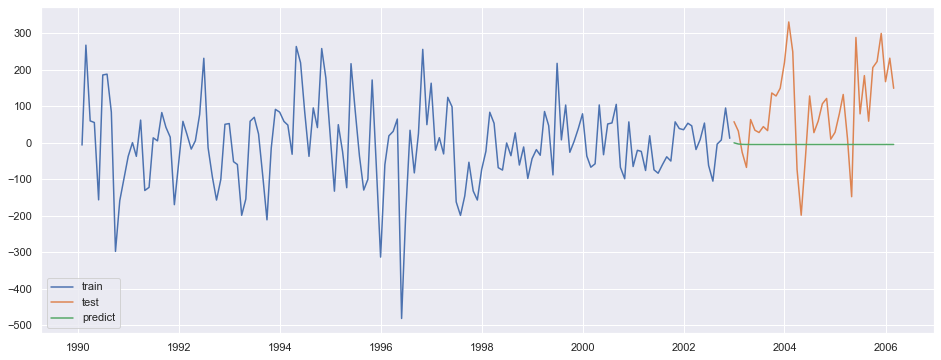

In [182]:
pred = results.predict(start=test.index[0], end=test.index[len(test)-1])

residuals = pred - test

print(f"ARIMA{model_order} MAE: {mae(residuals)}")
print(f"ARIMA{model_order} MAPE: {mape(pred, test)}")

fig = plt.figure(figsize=(16,6))

plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predict')

plt.legend(loc='best')

# Garbage Disposal

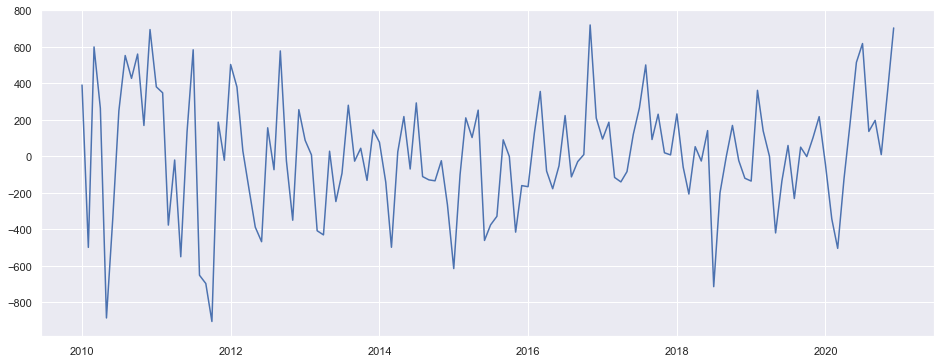

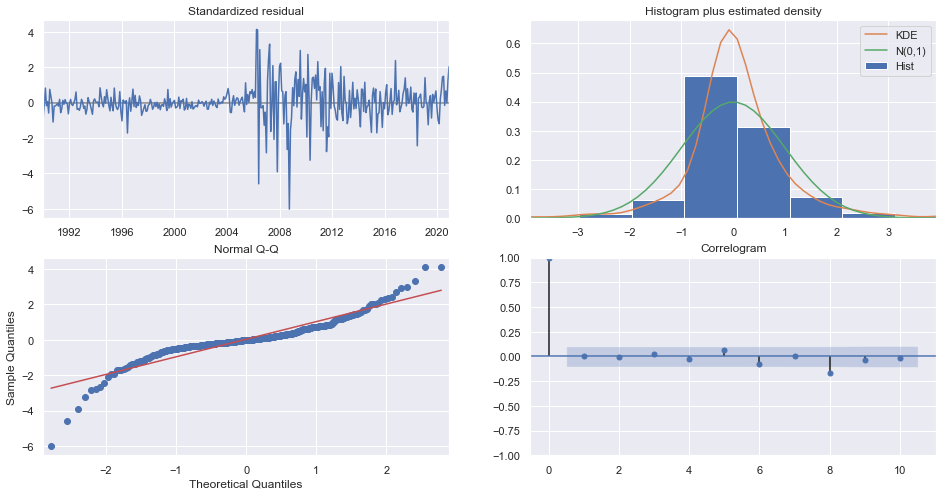

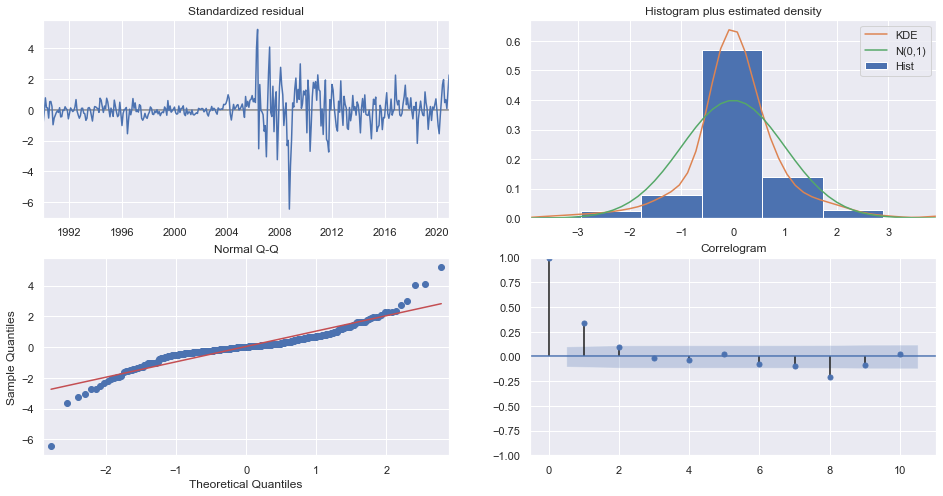

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox

fig = plt.figure(figsize=(16,6))

plt.plot(ts)

results_aic.plot_diagnostics(figsize=(16,8))
#print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

results_bic.plot_diagnostics(figsize=(16,8))
#print(acorr_ljungbox(results_bic.resid,  lags=[10], return_df=True))
plt.show()

202.71030338572285
616925.0264895665
                               SARIMAX Results                                
Dep. Variable:         COPPER_USD_TON   No. Observations:                  372
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2650.327
Date:                Sun, 17 Jan 2021   AIC                           5314.654
Time:                        11:23:00   BIC                           5342.086
Sample:                    01-01-1990   HQIC                          5325.548
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4363.7251   2200.826      1.983      0.047      50.185    8677.265
ar.L1          1.3026      0.762      1.710      0.087      -0.190       2.795
ar.L2         -

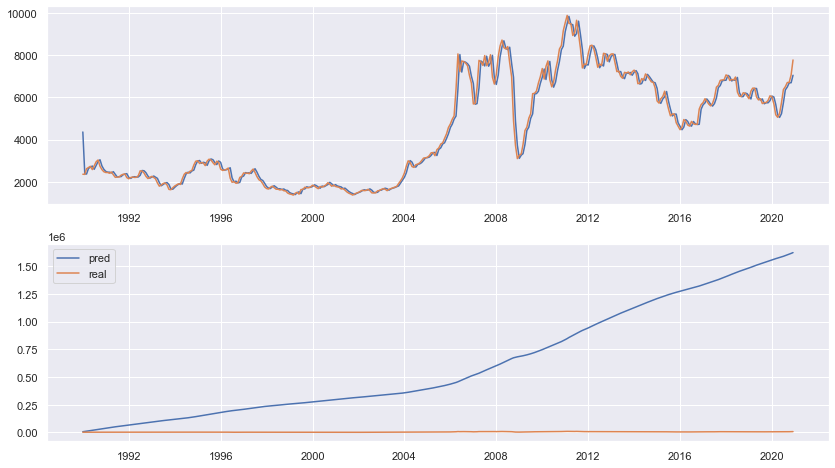

In [33]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,8))

#predict = results_bic.predict(dynamic=False)

fitted = results_bic.fittedvalues

fitt_int = fitted.cumsum() + df.COPPER_USD_TON[:][0]

residuals = ts - fitted

print(mae(residuals))
print(mae(fitt_int-df.COPPER_USD_TON[:]))

print(results_aic.summary())

ax1.plot(fitted.index, fitted, label='pred')
ax1.plot(ts.index, ts, label='real')

ax2.plot(fitt_int.index, fitt_int, label='pred')
ax2.plot(df.COPPER_USD_TON[:].index,  df.COPPER_USD_TON[:], label='real')

plt.legend(loc='best')
plt.show()

In [34]:
Fig = make_subplots(2, 1)

pred = results_bic.predict(start='02-01-1990', end='12-01-2004')

pred_undif = pred.cumsum() + df.COPPER_USD_TON[dt.date(1990,1,1): dt.date(2004,12,31)][0]

Fig.add_trace(go.Scatter(x=pred.index, y=pred, name='pred'), 1, 1)
Fig.add_trace(go.Scatter(x=ts[dt.date(1990,1,1): dt.date(2004,12,31)].index, y=ts[dt.date(1990,1,1): dt.date(2004,12,31)], name='real'), 1, 1)

Fig.add_trace(go.Scatter(x=pred_undif.index, y=pred_undif, name='pred'), 2, 1)
Fig.add_trace(go.Scatter(x=df.COPPER_USD_TON[dt.date(1990,1,1): dt.date(2004,12,31)].index,  y=df.COPPER_USD_TON[dt.date(1990,1,1): dt.date(2004,12,31)], name='real'), 2, 1)

Fig.show()

In [35]:
Fig = make_subplots(2, 1)

Fig.add_trace(go.Scatter(x=fitted.index, y=fitted, name='pred'), 1, 1)
Fig.add_trace(go.Scatter(x=ts.index, y=ts, name='real'), 1, 1)

Fig.add_trace(go.Scatter(x=fitt_int.index, y=fitt_int, name='pred'), 2, 1)
Fig.add_trace(go.Scatter(x=df.COPPER_USD_TON[:].index,  y=df.COPPER_USD_TON[:], name='real'), 2, 1)

Fig.show()

## FORECASTING 

### Manualy Differencing the Time Series

In [36]:
ts = df.COPPER_USD_TON.diff().dropna().asfreq('MS')

split = int(0.8*len(ts))

train = ts[:split]
test = ts[split:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

aic_order = (3,0,2)

bic_order = (1,0,0)

model = ARIMA(train, order=aic_order, trend='c')
results = model.fit()

print(f"ARIMA{aic_order} MAE: {mae(results.resid)}")

Train size: 296
Test size: 75
ARIMA(3, 0, 2) MAE: 179.4205767587559


Ljung-Box Test: lags=10
      lb_stat  lb_pvalue
10  20.736977   0.023004


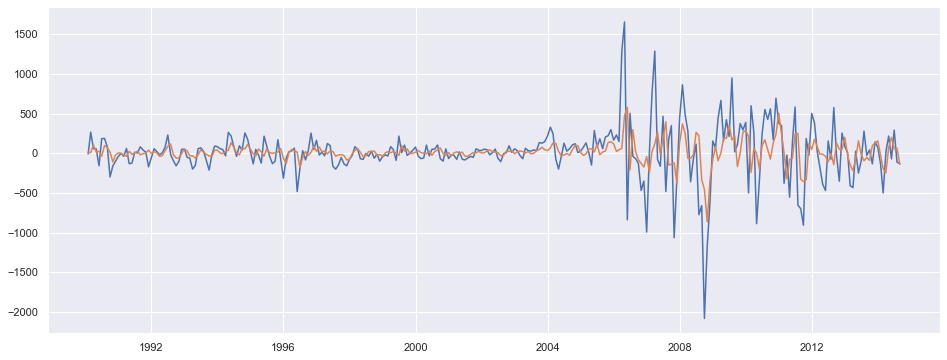

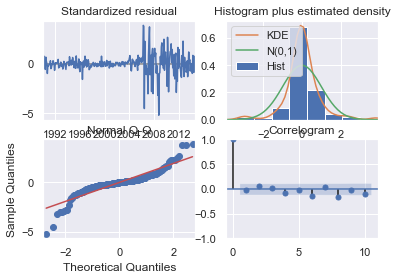

In [37]:
## model diagnostics

fig,ax = plt.subplots(figsize=(16,6))

print("Ljung-Box Test: lags=10")
print(acorr_ljungbox(results.resid,  lags=[10], return_df=True))

#print(f"Ljung-Box Test: lags={int(0.05*len(train))}")
#print(acorr_ljungbox(results_aic.resid,  lags=[int(0.05*len(train))], return_df=True))

ax.plot(train)
ax.plot(results.predict())

results.plot_diagnostics()

plt.show()

Prediction  MAE: 211.1065793199892


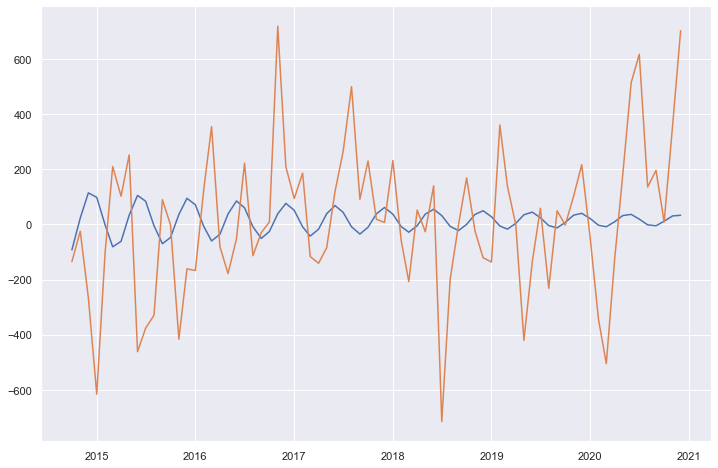

In [38]:
yhat = results.predict(start=test.index[0], end=test.index[len(test)-1])

print(f'Prediction  MAE: {mae(yhat-test)}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat)
ax.plot(test)

plt.show()

Prediction  MAE: 1527.5910339116112


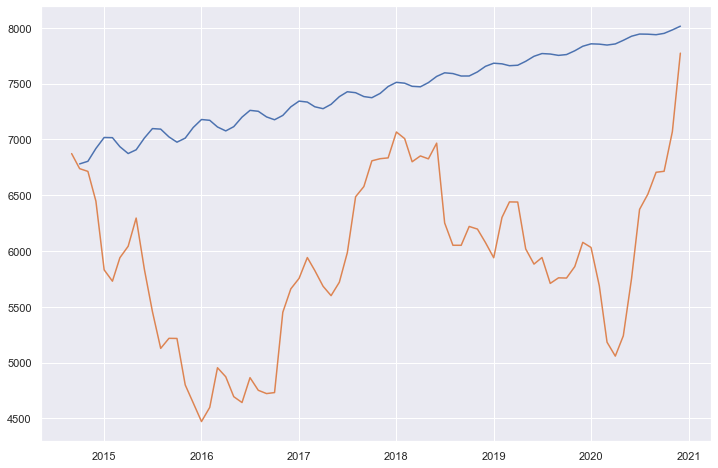

In [39]:
yhat_undiff = yhat.cumsum()+ df.COPPER_USD_TON[split:][0]

print(f'Prediction  MAE: {mae(yhat_undiff-df.COPPER_USD_TON[split:])}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat_undiff)
ax.plot(df.COPPER_USD_TON[split:])

plt.show()

### Withou Manualy Differencing


In [40]:

ts = df.COPPER_USD_TON.asfreq('MS')

p_order = 5
q_order = 5
d = 1

model_selection = []

aic_matrix = []
bic_matrix = []

for p in range(p_order+1):
    aic_tmp = []
    bic_tmp = []
    
    for q in range(q_order+1):
        model = ARIMA(ts, order=(p, d, q))
        results = model.fit()
        model_selection.append((p,q, results.aic, results.bic))
        aic_tmp.append(results.aic)
        bic_tmp.append(results.bic)
        
    aic_matrix.append(aic_tmp)
    bic_matrix.append(bic_tmp)

aic_matrix = np.matrix(aic_matrix).reshape(p_order+1,q_order+1)
bic_matrix = np.matrix(bic_matrix).reshape(p_order+1,q_order+1)
model_selection = pd.DataFrame(model_selection, columns=['p','q', 'aic', 'bic'])

print("AIC")
print(f"Minimum AIC: {aic_matrix.min()}")
display(pd.DataFrame(aic_matrix))

display(model_selection.loc[model_selection.aic==model_selection.aic.min()])

print("BIC")
print(f"Minimum BIC: {bic_matrix.min()}")
display(pd.DataFrame(bic_matrix))


display(model_selection.loc[model_selection.bic==model_selection.bic.min()])

AIC
Minimum AIC: 5281.03899539276


0            1            2            3            4  \
0  5334.469404  5293.680953  5291.300143  5293.327133  5292.821055   
1  5289.938706  5291.772308  5293.267012  5293.136183  5286.605964   
2  5291.715917  5290.853857  5294.773480  5286.425175  5287.192494   
3  5293.028324  5292.846676  5289.059980  5288.207807  5290.734368   
4  5294.931204  5287.432654  5287.968514  5293.725320  5286.240732   
5  5295.921926  5288.104539  5289.887224  5283.039969  5286.065748   

             5  
0  5292.264575  
1  5288.476811  
2  5289.052963  
3  5281.038995  
4  5292.794651  
5  5288.663533

p  q          aic          bic
23  3  5  5281.038995  5316.284814

BIC
Minimum BIC: 5297.771110136948


0            1            2            3            4  \
0  5338.385606  5301.513357  5303.048749  5308.991941  5312.402065   
1  5297.771110  5303.520914  5308.931821  5312.717193  5310.103176   
2  5303.464523  5306.518665  5314.354491  5309.922387  5314.605908   
3  5308.693132  5312.427686  5312.557192  5315.621222  5322.063985   
4  5314.512214  5310.929867  5315.381928  5325.054937  5321.486550   
5  5319.419138  5315.517953  5321.216841  5318.285787  5325.227769   

             5  
0  5315.761787  
1  5315.890225  
2  5320.382580  
3  5316.284814  
4  5331.956671  
5  5331.741756

p  q          aic         bic
6  1  0  5289.938706  5297.77111

In [41]:
ts = df.COPPER_USD_TON.asfreq('MS')

split = int(0.8*len(ts))

train = ts[:split]
test = ts[split:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

d = 1

aic_order = (3,d,5)

bic_order = (1,d,0)

model = ARIMA(train, order=aic_order, trend='c')
results = model.fit()

print(f"ARIMA{aic_order} MAE: {mae(results.resid[1:])}")

Train size: 297
Test size: 75
ARIMA(3, 1, 5) MAE: 183.17502084256628


Ljung-Box Test: lags=10
      lb_stat  lb_pvalue
10  13.376135   0.203395


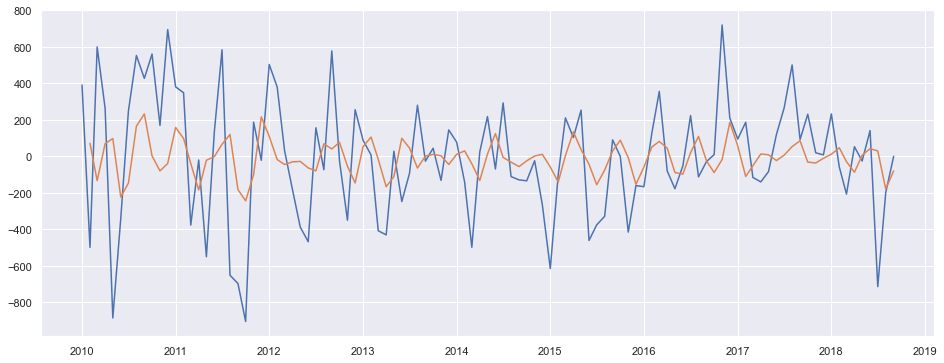

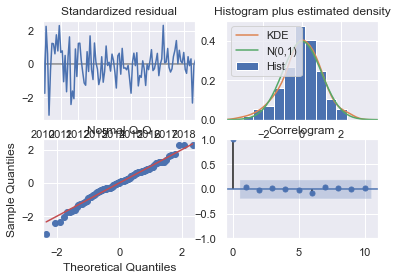

In [54]:
## model diagnostics

fig,ax = plt.subplots(figsize=(16,6))

print("Ljung-Box Test: lags=10")
print(acorr_ljungbox(results_aic.resid,  lags=[10], return_df=True))

#print(f"Ljung-Box Test: lags={int(0.05*len(train))}")
#print(acorr_ljungbox(results_aic.resid,  lags=[int(0.05*len(train))], return_df=True))

ax.plot(train)
ax.plot(results.predict()[1:])

results.plot_diagnostics()

plt.show()

Prediction  MAE: 1019.6495934233238


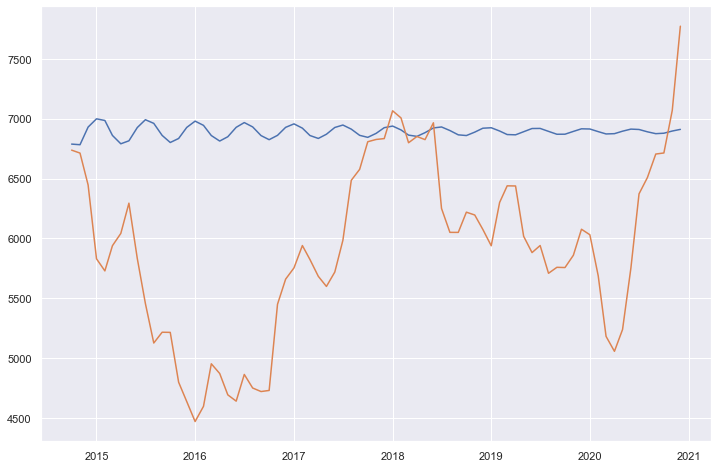

In [43]:
yhat = results.predict(start=test.index[0], end=test.index[len(test)-1])

print(f'Prediction  MAE: {mae(yhat-test)}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat)
ax.plot(test)

plt.show()

## REFINO

### Eliminating Outlier Periods

In [44]:
ts = df.COPPER_USD_TON.diff().dropna().asfreq('MS')
ts = ts[:dt.date(2004,1,1)]

stationary_test(ts, test='both')

order = (5,0,5)
aic_matrix, bic_matrix, model_selection = optmize_ARIMA(ts, order)

print("AIC")
print(f"Minimum AIC: {aic_matrix.min()}")
display(pd.DataFrame(aic_matrix))

display(model_selection.loc[model_selection.aic==model_selection.aic.min()])

print("BIC")
print(f"Minimum BIC: {bic_matrix.min()}")
display(pd.DataFrame(bic_matrix))


display(model_selection.loc[model_selection.bic==model_selection.bic.min()])

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



AIC
Minimum AIC: 2038.8195252617284


0            1            2            3            4  \
0  2061.503906  2046.194086  2048.110824  2049.272781  2051.180366   
1  2048.160788  2048.142532  2041.197970  2051.256702  2053.127913   
2  2047.276331  2049.227122  2049.280701  2040.514406  2050.191575   
3  2049.142212  2043.027033  2047.846108  2040.701090  2038.819525   
4  2049.422196  2049.520339  2044.840393  2042.645514  2039.665276   
5  2047.629841  2049.493244  2050.184290  2051.623231  2039.951243   

             5  
0  2051.771653  
1  2050.363144  
2  2047.256542  
3  2049.148736  
4  2045.762316  
5  2046.585718

p  q          aic          bic
22  3  4  2038.819525  2066.935201

BIC
Minimum BIC: 2055.5659783729425


0            1            2            3            4  \
0  2067.751834  2055.565978  2060.606680  2064.892601  2069.924150   
1  2057.532680  2060.638388  2056.817790  2070.000485  2074.995661   
2  2059.772187  2064.846942  2068.024484  2062.382154  2075.183287   
3  2064.762032  2061.770817  2069.713856  2065.692801  2066.935201   
4  2068.165980  2071.388087  2069.832104  2070.761189  2070.904916   
5  2069.497589  2074.484956  2078.299966  2082.862871  2074.314846   

             5  
0  2073.639401  
1  2075.354856  
2  2075.372218  
3  2080.388376  
4  2080.125920  
5  2084.073286

p  q          aic          bic
1  0  1  2046.194086  2055.565978

In [45]:
split = int(0.8*len(ts))

train = ts[:split]
test = ts[split:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

d = 0

aic_order = (3,d,4)

bic_order = (0,d,1)

model = ARIMA(train, order=aic_order, trend='c')
results = model.fit()

print(f"ARIMA{aic_order} MAE: {mae(results.resid[1:])}")

Train size: 134
Test size: 34
ARIMA(3, 0, 4) MAE: 78.7134588343142


Ljung-Box Test: lags=10
     lb_stat  lb_pvalue
10  7.799923   0.648373


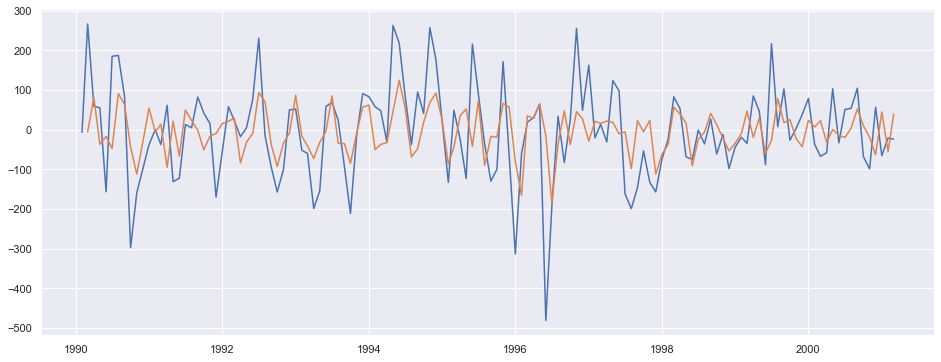

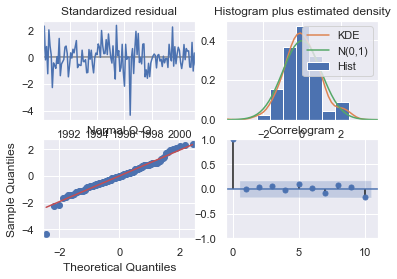

In [46]:
## model diagnostics

fig,ax = plt.subplots(figsize=(16,6))

print("Ljung-Box Test: lags=10")
print(acorr_ljungbox(results.resid,  lags=[10], return_df=True))

#print(f"Ljung-Box Test: lags={int(0.05*len(train))}")
#print(acorr_ljungbox(results_aic.resid,  lags=[int(0.05*len(train))], return_df=True))

ax.plot(train)
ax.plot(results.predict()[1:])

results.plot_diagnostics()

plt.show()

Prediction  MAE: 61.14084090408057


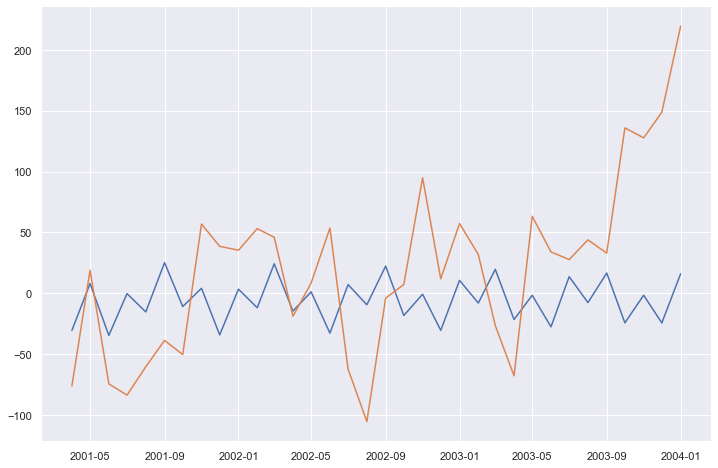

In [47]:
yhat = results.predict(start=test.index[0], end=test.index[len(test)-1])

print(f'Prediction  MAE: {mae(yhat-test)}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat)
ax.plot(test)

plt.show()

Prediction  MAE: 169.41544501449366


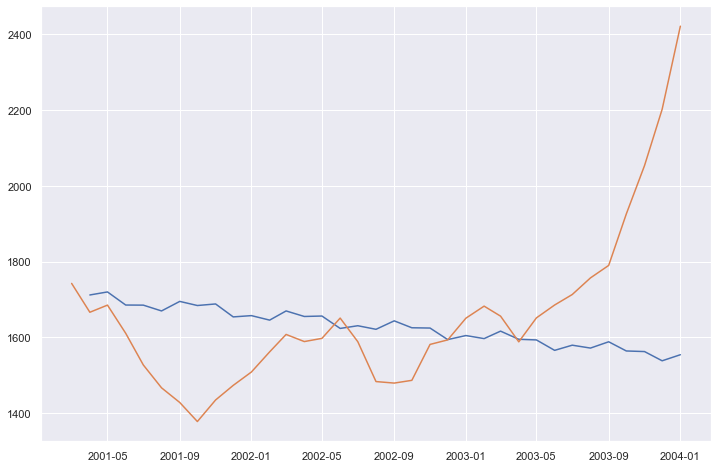

In [48]:
yhat_undiff = yhat.cumsum()+ df.COPPER_USD_TON[:dt.date(2004,1,1)][split:][0]

print(f'Prediction  MAE: {mae(yhat_undiff-df.COPPER_USD_TON[:dt.date(2004,1,1)][split:])}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat_undiff)
ax.plot(df.COPPER_USD_TON[:dt.date(2004,1,1)][split:])

plt.show()

In [49]:
ts = df.COPPER_USD_TON.diff().dropna().asfreq('MS')
ts = ts[dt.date(2010,1,1):]

stationary_test(ts, test='both')

order = (5,0,5)
aic_matrix, bic_matrix, model_selection = optmize_ARIMA(ts, order)

print("AIC")
print(f"Minimum AIC: {aic_matrix.min()}")
display(pd.DataFrame(aic_matrix))

display(model_selection.loc[model_selection.aic==model_selection.aic.min()])

print("BIC")
print(f"Minimum BIC: {bic_matrix.min()}")
display(pd.DataFrame(bic_matrix))


display(model_selection.loc[model_selection.bic==model_selection.bic.min()])

C:\Users\danie\anaconda3\envs\priceforecast\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



AIC
Minimum AIC: 1895.8045748375948


0            1            2            3            4  \
0  1904.410421  1895.804575  1897.398172  1898.082943  1898.281294   
1  1896.263468  1897.617803  1899.138626  1899.425191  1899.183084   
2  1897.089973  1898.094444  1897.630715  1899.259449  1900.784206   
3  1897.094402  1899.094267  1899.272467  1901.068127  1901.229834   
4  1899.094053  1898.770347  1899.848801  1903.750781  1905.039429   
5  1899.744288  1901.406848  1902.427968  1905.813267  1906.513884   

             5  
0  1899.820227  
1  1901.003659  
2  1903.177641  
3  1904.872939  
4  1908.939942  
5  1911.669049

p  q          aic          bic
1  0  1  1895.804575  1904.452981

BIC
Minimum BIC: 1904.452980605354


0            1            2            3            4  \
0  1910.176025  1904.452981  1908.929380  1912.496953  1915.578105   
1  1904.911874  1909.149010  1913.552636  1916.722003  1919.362698   
2  1908.621181  1912.508454  1914.927526  1919.439062  1923.846621   
3  1911.508412  1916.391079  1919.452080  1924.130542  1927.175051   
4  1916.390865  1918.949961  1922.911216  1929.695998  1933.867448   
5  1919.923902  1924.469263  1928.373185  1934.641286  1938.224705   

             5  
0  1919.999840  
1  1924.066074  
2  1929.122858  
3  1933.700959  
4  1940.650763  
5  1946.262672

p  q          aic          bic
1  0  1  1895.804575  1904.452981

In [50]:
split = int(0.8*len(ts))

train = ts[:split]
test = ts[split:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

d = 0

aic_order = (3,d,4)

bic_order = (2,d,2)

model = ARIMA(train, order=bic_order, trend='c')
results = model.fit()

print(f"ARIMA{bic_order} MAE: {mae(results.resid[1:])}")

Train size: 105
Test size: 27
ARIMA(2, 0, 2) MAE: 245.07321522515835


Ljung-Box Test: lags=10
     lb_stat  lb_pvalue
10  1.368852   0.999289


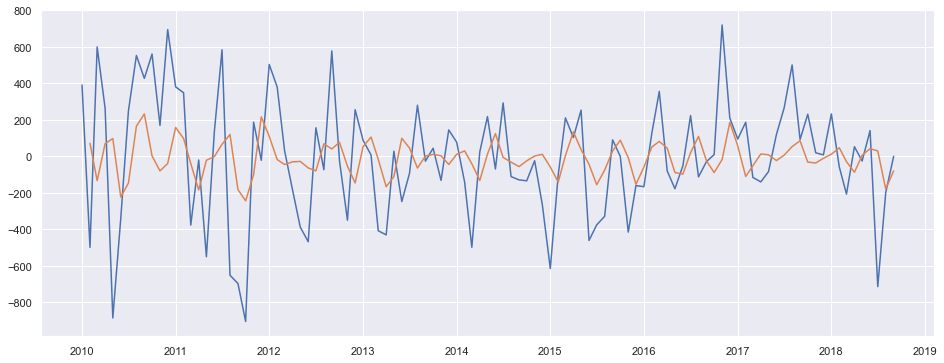

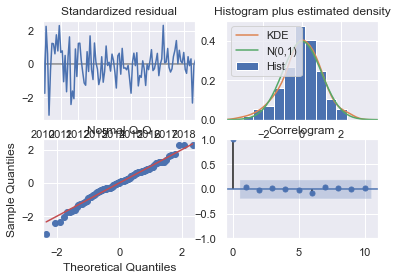

In [51]:
## model diagnostics

fig,ax = plt.subplots(figsize=(16,6))

print("Ljung-Box Test: lags=10")
print(acorr_ljungbox(results.resid,  lags=[10], return_df=True))

#print(f"Ljung-Box Test: lags={int(0.05*len(train))}")
#print(acorr_ljungbox(results_aic.resid,  lags=[int(0.05*len(train))], return_df=True))

ax.plot(train)
ax.plot(results.predict()[1:])

results.plot_diagnostics()

plt.show()

Prediction  MAE: 216.38033772273567


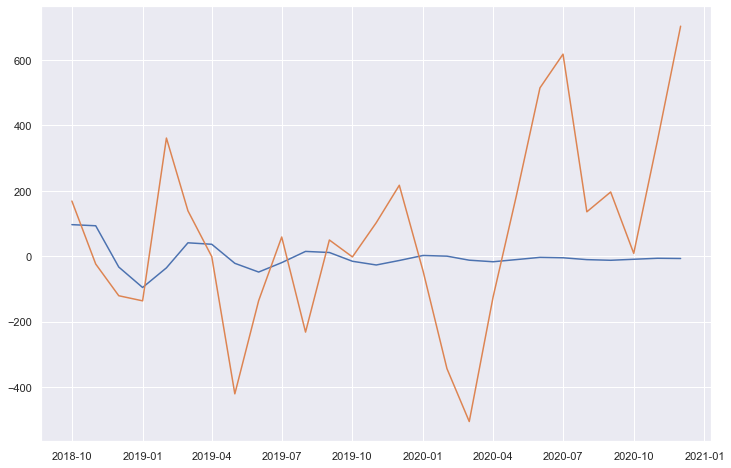

In [52]:
yhat = results.predict(start=test.index[0], end=test.index[len(test)-1])

print(f'Prediction  MAE: {mae(yhat-test)}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat)
ax.plot(test)

plt.show()

Prediction  MAE: 471.71550498519343


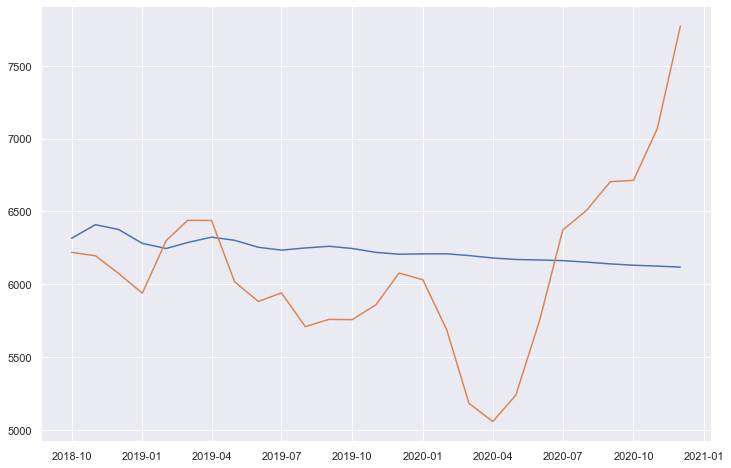

In [53]:
yhat_undiff = yhat.cumsum()+ df.COPPER_USD_TON[dt.date(2010,1,1):][split:][0]

print(f'Prediction  MAE: {mae(yhat_undiff-df.COPPER_USD_TON[dt.date(2010,1,1):][split:])}')

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(yhat_undiff)
ax.plot(df.COPPER_USD_TON[dt.date(2010,1,1):][split:])

plt.show()